In [12]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
from ridgeplot import ridgeplot
import joypy
import seaborn as sns
from matplotlib import cm
import climpred
from xclim import sdba
from climpred.options import OPTIONS
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from function import funs as f
from function import preprocessUtils as putils
from function import masks
from function import verifications
from function import conf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fcst_source = 'GEFSv12' #['GEFSv12','ECMWF']

In [4]:
dir = '/glade/work/klesinger/FD_RZSM_deep_learning'

global dim_order
dim_order = ['S','M','L','Y','X']

In [5]:
test_start = '2018-01-01'
test_end = '2019-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
train_start  = '2000-01-01'

leads_ = [6,13,20,27,34]

In [11]:
#Set script parameters
global region_name
region_name = 'CONUS' #['CONUS','australia','china']

mask = masks.load_mask(region_name)

if region_name == 'CONUS':
    region_mask = masks.load_mask(region_name).rename({'Y':'lat','X':'lon'})
    CONUS_region_names = {1:'Northeast',2:'Southeast',3:'Midwest',4:'Great Plains',5:'Northwest',6:'Southwest'}
    #Mask with np.nan for non-CONUS land values
    mask_anom = mask[putils.xarray_varname(mask)][:,:].values




In [5]:

#Load observation anomaly as raw file
if region_name == 'CONUS':
    source = f"{conf.gleam_data}/{region_name}"
    gefs_source = f"{conf.gefsv12_data}/{region_name}"


global obs_original,obs_raw
obs_original = xr.open_dataset(f'{source}/RZSM_anomaly.nc').rename({'SMsurf':'RZSM'}).load()
obs_raw = xr.open_dataset(f'{source}/RZSM_weighted_mean_0_100cm.nc4').rename({'SMsurf':'RZSM'}).load()

init_dates = putils.get_init_date_list(f'{gefs_source}/soilw_bgrnd')
dt_dates = [pd.to_datetime(i) for i in init_dates]

only_testing_dates = [i for i in dt_dates if i >= pd.to_datetime('2018-01-01')]

ecmwf_files_all = sorted(glob(f'{conf.ecmwf_data}/{region_name}/soilw_bgrnd/soil*'))

correct_ecmwf_files = [i for i in ecmwf_files_all if any(init_date in i for init_date in init_dates)]

#Get data for the additive bias correction
ecmwf_raw = xr.open_mfdataset(correct_ecmwf_files)

gefs_raw = putils.return_reforecast_files_by_concatenation(dir_path = gefs_source, name_of_var = 'soilw_bgrnd', region_name = region_name)

#We have different coordinate systems. So we need to add 360 to each of the X coordinates if they are negative
if region_name == 'CONUS':
    print(f'We are changing the coordinates of CONUS to match similar format as GLEAM')
    new_X_coords = [i+360 if i < 0 else i for i in ecmwf_raw.X.values] #same as putils.create_new_X_coord_values
    #Add the new coordinates
    ecmwf_raw = ecmwf_raw.assign_coords({'X':new_X_coords})
    ecmwf_raw = putils.restrict_to_bounding_box(ecmwf_raw,mask)

    obs_raw = putils.restrict_to_bounding_box(obs_raw,mask)



Latitude values for mask is [50.  49.5 49.  48.5 48.  47.5 47.  46.5 46.  45.5 45.  44.5 44.  43.5
 43.  42.5 42.  41.5 41.  40.5 40.  39.5 39.  38.5 38.  37.5 37.  36.5
 36.  35.5 35.  34.5 34.  33.5 33.  32.5 32.  31.5 31.  30.5 30.  29.5
 29.  28.5 28.  27.5 27.  26.5]

Longitude values for mask is [238.  238.5 239.  239.5 240.  240.5 241.  241.5 242.  242.5 243.  243.5
 244.  244.5 245.  245.5 246.  246.5 247.  247.5 248.  248.5 249.  249.5
 250.  250.5 251.  251.5 252.  252.5 253.  253.5 254.  254.5 255.  255.5
 256.  256.5 257.  257.5 258.  258.5 259.  259.5 260.  260.5 261.  261.5
 262.  262.5 263.  263.5 264.  264.5 265.  265.5 266.  266.5 267.  267.5
 268.  268.5 269.  269.5 270.  270.5 271.  271.5 272.  272.5 273.  273.5
 274.  274.5 275.  275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5
 280.  280.5 281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5]

Loading files for variable soilw_bgrnd
We are changing the coordinates of CONUS to match similar format as GLE

In [44]:
#Open the gleam percentile/anom files
obs_anom_percentile = xr.open_mfdataset(f'{source}/RZSM_anom_and_percentile_reformat/*').sel(S=slice(test_start,test_end))
obs_anom_percentile['S'] = only_testing_dates

ValueError: conflicting sizes for dimension 'S': length 104 on 'S' and length 1 on {'S': '5th_percentile', 'M': '5th_percentile', 'L': '5th_percentile', 'Y': '5th_percentile', 'X': '5th_percentile'}

In [7]:
# obs_anom_percentile['RZSM_percentile'][iData,0,0,10,10].values

In [8]:
'''CLIMPRED functions won't work on this data for some reason. Just skip it'''

# if region_name =='CONUS':
#     baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
#     baseline_anomaly_climatology = xr.open_mfdataset(baseline_anomaly_file_list).sel(S=slice(train_start,val_end)).astype(np.float32).load()

# elif region_name == 'australia':
#     baseline_anomaly_file_list = sorted(glob('Data_australia/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
#     baseline_anomaly_climatology = xr.open_mfdataset(baseline_anomaly_file_list).sel(S=slice(train_start,val_end)).astype(np.float32).load()
#     baseline_anomaly_climatology = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)

# baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
# baseline_ecmwf_climatology = xr.open_mfdataset(baseline_ecmwf_file_list).sel(S=slice(train_start,val_end)).astype(np.float32).load()


# test_dates_subx = only_testing_dates
# baseline_anomaly_climatology

"CLIMPRED functions won't work on this data for some reason. Just skip it"

In [9]:
''' Load EMOS results (only for CONUS). We have not completed EMOS on any other region except CONUS'''
if region_name == 'CONUS':
    emos_ = xr.open_dataset('Data/EMOS/EMOS_11_test_predictions_12_weeks_before.nc')
    emos_ = emos_.rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'})

test_dates_subx = only_testing_dates

In [10]:
gefs_raw

<xarray.Dataset>
Dimensions:  (S: 1043, M: 11, L: 35, Y: 48, X: 96)
Coordinates:
  * X        (X) float64 238.0 238.5 239.0 239.5 ... 284.0 284.5 285.0 285.5
  * Y        (Y) float64 50.0 49.5 49.0 48.5 48.0 ... 28.5 28.0 27.5 27.0 26.5
  * L        (L) int32 0 1 2 3 4 5 6 7 8 9 10 ... 25 26 27 28 29 30 31 32 33 34
  * M        (M) int32 0 1 2 3 4 5 6 7 8 9 10
  * S        (S) datetime64[ns] 2000-01-05 2000-01-12 ... 2019-12-18 2019-12-25
Data variables:
    RZSM     (S, M, L, Y, X) float32 0.4235 0.4173 0.3967 0.3015 ... 1.0 1.0 1.0
Attributes:
    Description:  Volumetric soil moisture content 0-100cm: 0.0-0.1, 0.1-0.4,...

In [11]:
#Now bias correct and then take the anomaly
    
climpred.set_options(seasonality="season") 
seasonality_str = OPTIONS["seasonality"]

def return_seasonal_mean(file,train_end):
    climatology_season = file.sel(init=(file['init.year'] <= train_end)).groupby(f"init.{seasonality_str}").mean()
    return(climatology_season)

def compute_anomaly_on_testing(full_file, train_end, test_file):
    climatology_season = return_seasonal_mean(full_file,train_end)
    climatology_season = climatology_season.rename({'member':'M','lead':'L','lat':'Y','lon':'X'})
    
    summer_= test_file.sel(S=(test_file['S.season']=='JJA')) - climatology_season.sel(season='JJA')
    fall_= test_file.sel(S=(test_file['S.season']=='SON'))- climatology_season.sel(season='SON')
    winter_= test_file.sel(S=(test_file['S.season']=='DJF'))- climatology_season.sel(season='DJF')
    spring_= test_file.sel(S=(test_file['S.season']=='MAM'))- climatology_season.sel(season='MAM')

    combined_files = xr.concat([summer_,fall_,winter_,spring_],dim='S').sortby('S')
    combined_files = combined_files.drop('season')
    return(combined_files)

# Set up data for additive bias correction
bias_correct_gefs = verifications.rename_subx_for_climpred(gefs_raw)
# baseline_anomaly_climatology
bias_correct_gefs['init'] = ecmwf_raw.S.values

bias_correct_ecmwf = verifications.rename_subx_for_climpred(ecmwf_raw)
bias_correct_ecmwf['init'] = ecmwf_raw.S.values

obs_full = verifications.rename_obs_for_climpred(obs_raw)

bias_correct_gefs = bias_correct_gefs.sel(lead=[6,13,20,27,34])
bias_correct_ecmwf = bias_correct_ecmwf.sel(lead=[6,13,20,27,34])

#Now apply additive bias correction algorithm
additive_bias_gefs = verifications.additive_bias_removal(bias_correct_gefs,obs_full).get_initialized().sel(init=slice(test_start,test_end))
additive_bias_ecmwf = verifications.additive_bias_removal(bias_correct_ecmwf,obs_full).get_initialized().sel(init=slice(test_start,test_end))

additive_bias_gefs = additive_bias_gefs.rename({'init':'S','member':'M','lead':'L','lat':'Y','lon':'X'})
additive_bias_ecmwf = additive_bias_ecmwf.rename({'init':'S','member':'M','lead':'L','lat':'Y','lon':'X'})

additive_bias_gefs['S'] = test_dates_subx
additive_bias_ecmwf['S'] = test_dates_subx

additive_bias_ecmwf = additive_bias_ecmwf.drop('valid_time').load()
additive_bias_gefs = additive_bias_gefs.drop('valid_time').load()

/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:987: UserWarning: HindcastEnsemble is chunked along dimensions ['init'] with more than one chunk. `HindcastEnsemble.chunks=Frozen({'init': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
#This what we will now be computing the skill on 

additive_bias_gefs_final = compute_anomaly_on_testing(bias_correct_gefs, 2015, additive_bias_gefs)
additive_bias_ecmwf_final = compute_anomaly_on_testing(bias_correct_ecmwf, 2015, additive_bias_ecmwf)

In [13]:
obs_original = obs_original.drop('season')

# Data

In [14]:
def open_obs_and_baseline_files_with_climatology(region_name, lead, day_num, test_start, test_end):

    obs_anomaly_SubX_format =xr.open_mfdataset(f'Data/GLEAM/RZSM_anomaly_reformat_SubX_format/{region_name}/RZSM_anomaly*.nc4').sel(L=[day_num]).astype(np.float32).load()
    obs_anomaly_SubX_format = obs_anomaly_SubX_format.sel(S=slice(test_start,test_end))
    
    template_testing_only = obs_anomaly_SubX_format.copy(deep=True)
    
    var_OUT = np.empty(shape=(obs_anomaly_SubX_format.Y.shape[0], obs_anomaly_SubX_format.X.shape[0])) #48x96
    
    #Mask the final output to be np.nan for ocean values
    var_OUT = np.where(mask_anom==1, np.nan, var_OUT)
    var_OUT[:,:] = 0
    
    #######################################   Reforecast baseline files   ###########################################################################
    # baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
    if region_name =='CONUS':
        baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        
    else:
        baseline_anomaly_file_list = sorted(glob(f'Data_{region_name}/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        baseline_anomaly = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)
    
    baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
    baseline_ecmwf = xr.open_mfdataset(baseline_ecmwf_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
    
    
    #Need to open a template of ECMWF to mask the np.nan values that
    return(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only)
        

In [15]:
def open_obs_and_baseline_files(region_name, lead, day_num, test_start, test_end):

    obs_anomaly_SubX_format =xr.open_mfdataset(f'Data/GLEAM/RZSM_anomaly_reformat_SubX_format/{region_name}/RZSM_anomaly*.nc4').sel(L=[day_num]).astype(np.float32).load()
    obs_anomaly_SubX_format = obs_anomaly_SubX_format.sel(S=slice(test_start,test_end))
    
    template_testing_only = obs_anomaly_SubX_format.copy(deep=True)
    
    var_OUT = np.empty(shape=(obs_anomaly_SubX_format.Y.shape[0], obs_anomaly_SubX_format.X.shape[0])) #48x96
    
    #Mask the final output to be np.nan for ocean values
    var_OUT = np.where(mask_anom==1, np.nan, var_OUT)
    var_OUT[:,:] = 0
    
    #######################################   Reforecast baseline files   ###########################################################################
    # baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
    if region_name =='CONUS':
        baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
    
    else:
        baseline_anomaly_file_list = sorted(glob(f'Data_{region_name}/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        baseline_anomaly = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)
    
    baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
    baseline_ecmwf = xr.open_mfdataset(baseline_ecmwf_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()

    
    #Need to open a template of ECMWF to mask the np.nan values that
    return(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only)
        

In [16]:

#Empirical quantile mapping 
# empirial_bias_gefs = empirial_quantile_mapping_bias_correction(bias_correct_gefs,obs_full) #doesn't work, it can't find the sdba package even thought its loaded

In [17]:
def open_obs_and_baseline_files_multiple_leads(region_name, leads, test_start, test_end):
    print('Loading all the baseline files for observations, GEFSv12, and ECMWF')
    
    obs_anomaly_SubX_format =xr.open_mfdataset(f'Data/GLEAM/RZSM_anomaly_reformat_SubX_format/{region_name}/RZSM_anomaly*.nc4').sel(L=leads).astype(np.float32).load()
    obs_anomaly_SubX_format = obs_anomaly_SubX_format.sel(S=slice(test_start,test_end)).load()
    
    template_testing_only = obs_anomaly_SubX_format.copy(deep=True)
    
    var_OUT = np.empty(shape=(obs_anomaly_SubX_format.Y.shape[0], obs_anomaly_SubX_format.X.shape[0])) #48x96
    
    #Mask the final output to be np.nan for ocean values
    var_OUT = np.where(mask_anom==1, np.nan, var_OUT)
    var_OUT[:,:] = 0
    
    #######################################   Reforecast baseline files   ###########################################################################
    # baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
    if region_name =='CONUS':
        baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=leads).sel(S=slice(test_start,test_end)).astype(np.float32).load()

    else:
        baseline_anomaly_file_list = sorted(glob(f'Data_{region_name}/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=leads).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        baseline_anomaly = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)
    
    baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
    baseline_ecmwf = xr.open_mfdataset(baseline_ecmwf_file_list).sel(L=leads).sel(S=slice(test_start,test_end)).astype(np.float32).load()
    
    
    #Need to open a template of ECMWF to mask the np.nan values that
    return(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only)
        

# Just open up all the baseline files for faster processing

In [18]:
global obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only

obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files_multiple_leads(region_name, leads_, test_start, test_end)

Loading all the baseline files for observations, GEFSv12, and ECMWF


In [20]:
def expand_dims_by_lead(file):
    return(file.expand_dims({'L':1}).transpose(*dim_order))

In [138]:
def select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num):
    obs_lead = expand_dims_by_lead(obs_anomaly_SubX_format.sel(L=day_num))
    baseline_gefs =  expand_dims_by_lead(baseline_anomaly.sel(L=day_num))
    baseline_ecm =  expand_dims_by_lead(baseline_ecmwf.sel(L=day_num))
    var_OUT = var_OUT
    template =  expand_dims_by_lead(template_testing_only.sel(L=day_num))
    return(obs_lead,baseline_gefs,baseline_ecm,var_OUT,template)

In [50]:
def setup_ridgeplot_array(metric_dict,week_lead, region_name,metric_name,xlim_start,xlim_end):
    #Need to make the data into an array where:
    # ROWS = number of different realizations (so approximatley 15)
    # COLS = values (ACC or CRPS)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    # to return a group of the key-value
    # # pairs in the dictionary
    # result = metric_dict.items()
     
    # # Convert object to a list
    # data = list(result)
     
    # # Convert list to an array
    # numpyArray = np.array(data)
     
    # # print the numpy array
    # print(numpyArray)
    #convert to a dataframe
    df = pd.DataFrame(metric_dict).T

    if metric_name == 'CRPS':
        joypy.joyplot(df.T,colormap=cm.autumn_r,
                     title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(0,0.05))
    else:
        joypy.joyplot(df.T,colormap=cm.autumn_r,
             title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(xlim_start,xlim_end))
        
    plt.savefig(f'{save_dir}/Wk{week_lead}_{metric_name}.png')

    # colormap=cm.autumn_r
    # list_df = []
    # name_df = list(df.index)
    
    # for i in range(len(df)):
    #     list_df.append(np.array(df.iloc[i,:]))

    # fig = ridgeplot(samples = list_df,
    #                labels=name_df)
    # fig.update_layout(height=500, width=800)
    # fig.show()

    #Need to find the number of columns based on gefs

    return('Completed')


In [51]:
def setup_improvement_over_baseline_by_region_image(metric_dict,week_lead, region_name,metric_name,xlim_start,xlim_end):
    #Need to make the data into an array where:
    # ROWS = number of different realizations (so approximatley 15)
    # COLS = values (ACC or CRPS)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    # to return a group of the key-value
    # # pairs in the dictionary
    # result = metric_dict.items()
     
    # # Convert object to a list
    # data = list(result)
     
    # # Convert list to an array
    # numpyArray = np.array(data)
     
    # # print the numpy array
    # print(numpyArray)
    #convert to a dataframe
    df = pd.DataFrame(metric_dict).T

    if metric_name == 'CRPS':
        joypy.joyplot(df.T,colormap=cm.autumn_r,
                     title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(0,0.05))
    else:
        joypy.joyplot(df.T,colormap=cm.autumn_r,
             title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(xlim_start,xlim_end))
        
    plt.savefig(f'{save_dir}/Wk{week_lead}_{metric_name}.png')

    # colormap=cm.autumn_r
    # list_df = []
    # name_df = list(df.index)
    
    # for i in range(len(df)):
    #     list_df.append(np.array(df.iloc[i,:]))

    # fig = ridgeplot(samples = list_df,
    #                labels=name_df)
    # fig.update_layout(height=500, width=800)
    # fig.show()

    #Need to find the number of columns based on gefs

    return('Completed')


In [ ]:
# def ridgeplot_ACC_MEM(week_lead, region_name, test_start, test_end):

#     day_num = (week_lead*7) -1
    
#     print('Loading observation and baseline anomaly files')
#     obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                     test_start = test_start, test_end = test_end)
#     metric_dict = {}
    
#     #Test 
#     gefs = baseline_anomaly
#     ecmwf = baseline_ecmwf
#     obs = obs_anomaly_SubX_format

#     obs = obs.mean(dim='M')
#     gefs = gefs.mean(dim='M')
#     ecmwf = ecmwf.mean(dim='M')

    
#     #First get the ACC values of GEFS and ECMWF relative to observations
#     gefs_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                     forecast_converted=gefs[putils.xarray_varname(gefs)].to_numpy(),
#                                                                                     obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()
    
#     ecmwf_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                     forecast_converted=ecmwf[putils.xarray_varname(ecmwf)].to_numpy(),
#                                                                                     obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()
#     #First get any missing values from ECMWF to properly construct ridgeplot
#     ec_not_nan = ~np.isnan(ecmwf_acc)

#     gefs_acc = gefs_acc[ec_not_nan]
#     ecmwf_acc = ecmwf_acc[ec_not_nan]
    
#     metric_dict.update({'GEFSv12': gefs_acc, 'ECMWF': ecmwf_acc})
    
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         test_name = i.split('testing_')[-1].split('.npy')[0]
#         test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#         test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#         #Take the mean of models
#         test = np.nanmean(test,axis=1)
#         unet_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                 forecast_converted=test,
#                                                                                 obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()

#         unet_acc = unet_acc[ec_not_nan]
        
#         metric_dict.update({test_name: unet_acc})
    
#     setup_ridgeplot_array(metric_dict,week_lead, region_name,metric_name='ACC')

#     return('Completed')
    

In [101]:
def ridgeplot_ACC_climpred_with_XGBOOST(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):
    
    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    #For a single lead
    obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)

    print('Calculating ACC on GEFS and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    def flatten_files(file):
        return(file[putils.xarray_varname(file)].values.flatten())

    print('Masking land values for GEFS and ECMWF')
    gefs_acc = flatten_files(gefs_acc)
    gefs_BC_acc = flatten_files(gefs_BC_acc)
    ecmwf_acc = flatten_files(ecmwf_acc)
    ecmwf_BC_acc = flatten_files(ecmwf_BC_acc)
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    gefs_BC_acc = gefs_BC_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    ecmwf_BC_acc = ecmwf_BC_acc[ec_not_nan]

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
        
    df = pd.DataFrame()
    df = add_to_dataframe(df, ecmwf_acc, 'ECMWF')
    df = add_to_dataframe(df, ecmwf_BC_acc, 'ECMWF_BC')
    df = add_to_dataframe(df, gefs_acc, 'GEFSv12')
    df = add_to_dataframe(df, gefs_BC_acc, 'GEFSv12_BC')
    
    ####################################################################################################################################
    
    #Load the XGBoost data
    if region_name == 'CONUS':
        print('Working on XGBoost experiments')
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*'))
    
        #Now loop through and open file, convert to anomaly and compute ACC score
        for i in xgboost_files:
            # break
            add_to_file = gefs.copy(deep = True)
            # break
            #Still working here
            test_name = i.split('testing_')[-1].split('.npy')[0]
            load_ = np.expand_dims(np.load(i),-1)
            load_.shape
            load_ = np.where(load_ == 0,np.nan,load_)
            add_realizations = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
            for j in range(11):
                add_realizations[:,j,:,:,:] = load_
            add_realizations = verifications.reverse_min_max_scaling(add_realizations, region_name, day_num)
            add_realizations.shape
            add_realizations =  np.reshape(add_realizations,(add_realizations.shape[0], add_realizations.shape[1], add_realizations.shape[-1], add_realizations.shape[2], add_realizations.shape[3])) #Reshape to match gefs/ecmwf
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = add_realizations
            xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            xg_acc = xg_acc.acc.values.flatten()
            xg_acc = xg_acc[ec_not_nan]
            df = add_to_dataframe(df, xg_acc, test_name)
    
    print('Adding EMOS results')
    #Now add EMOS results
    if region_name == 'CONUS':
        emos_select = emos_.sel(L=day_num)
        
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    
        emos_final = emos_acc.sel(lead=day_num).acc.values.flatten()
        emos_final = emos_final[ec_not_nan]
        df = add_to_dataframe(df, emos_final, 'EMOS')

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}')) #Will all data
    
    print('Working on UNET experiments')
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                unet_acc = unet_acc.acc.values.flatten()
                unet_acc = unet_acc[ec_not_nan]
                df = add_to_dataframe(df, unet_acc, test_name)

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            unet_acc = unet_acc.acc.values.flatten()
            unet_acc = unet_acc[ec_not_nan]
            df = add_to_dataframe(df, unet_acc, test_name)
        

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    if single_experiment_or_all_experiments == 'all':
        joypy.joyplot(df,colormap=cm.autumn_r,
                     title=f"ACC by Experiment Week {week_lead}",
                     fade=True,figsize=(10,30))
    else:
        joypy.joyplot(df,colormap=cm.autumn_r,
             title=f"ACC by Experiment Week {week_lead}",
             fade=True,figsize=(5,10))


    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred.png')

    return('Completed')
    

In [85]:
def ridgeplot_ACC_climpred_only_UNET(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):

    
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    #For a single lead
    obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)

    print('Calculating ACC on GEFSv12 and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    def flatten_files(file):
        return(file[putils.xarray_varname(file)].values.flatten())

    print('Masking files with np.nan values')
    gefs_acc = flatten_files(gefs_acc)
    gefs_BC_acc = flatten_files(gefs_BC_acc)
    ecmwf_acc = flatten_files(ecmwf_acc)
    ecmwf_BC_acc = flatten_files(ecmwf_BC_acc)
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    gefs_BC_acc = gefs_BC_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    ecmwf_BC_acc = ecmwf_BC_acc[ec_not_nan]

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
        
    df = pd.DataFrame()
    df = add_to_dataframe(df, ecmwf_acc, 'ECMWF')
    df = add_to_dataframe(df, ecmwf_BC_acc, 'ECMWF_BC')
    df = add_to_dataframe(df, gefs_acc, 'GEFSv12')
    df = add_to_dataframe(df, gefs_BC_acc, 'GEFSv12_BC')

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data
    
   
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
        unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        unet_acc = unet_acc.acc.values.flatten()
        unet_acc = unet_acc[ec_not_nan]
        df = add_to_dataframe(df, unet_acc, test_name)
        

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    if single_experiment_or_all_experiments == 'all':
        joypy.joyplot(df,colormap=cm.autumn_r,
                     title=f"ACC by Experiment Week {week_lead}",
                     fade=True,figsize=(10,30))
    else:
        joypy.joyplot(df,colormap=cm.autumn_r,
             title=f"ACC by Experiment Week {week_lead}",
             fade=True,figsize=(5,10))


    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred.png')

    # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
    #     # break
    #     plot_ = out_df[out_df['Reference'] == i]
        
    #     joypy.joyplot(plot_,colormap=cm.autumn_r,
    #                  title=f"{i} by Experiment Week {week_lead}",
    #                  fade=True)
    #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
    # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
    # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
    return('Completed')
    

Loading observation and baseline anomaly files
Calculating ACC on GEFS and ECMWF
Masking land values for GEFS and ECMWF
Working on XGBoost experiments
Adding EMOS results
Working on UNET experiments
Loading observation and baseline anomaly files
Calculating ACC on GEFS and ECMWF
Masking land values for GEFS and ECMWF
Working on XGBoost experiments
Adding EMOS results
Working on UNET experiments
Loading observation and baseline anomaly files
Calculating ACC on GEFS and ECMWF
Masking land values for GEFS and ECMWF
Working on XGBoost experiments
Adding EMOS results
Working on UNET experiments
Loading observation and baseline anomaly files
Calculating ACC on GEFS and ECMWF
Masking land values for GEFS and ECMWF
Working on XGBoost experiments
Adding EMOS results
Working on UNET experiments
Loading observation and baseline anomaly files
Calculating ACC on GEFS and ECMWF
Masking land values for GEFS and ECMWF
Working on XGBoost experiments
Adding EMOS results
Working on UNET experiments


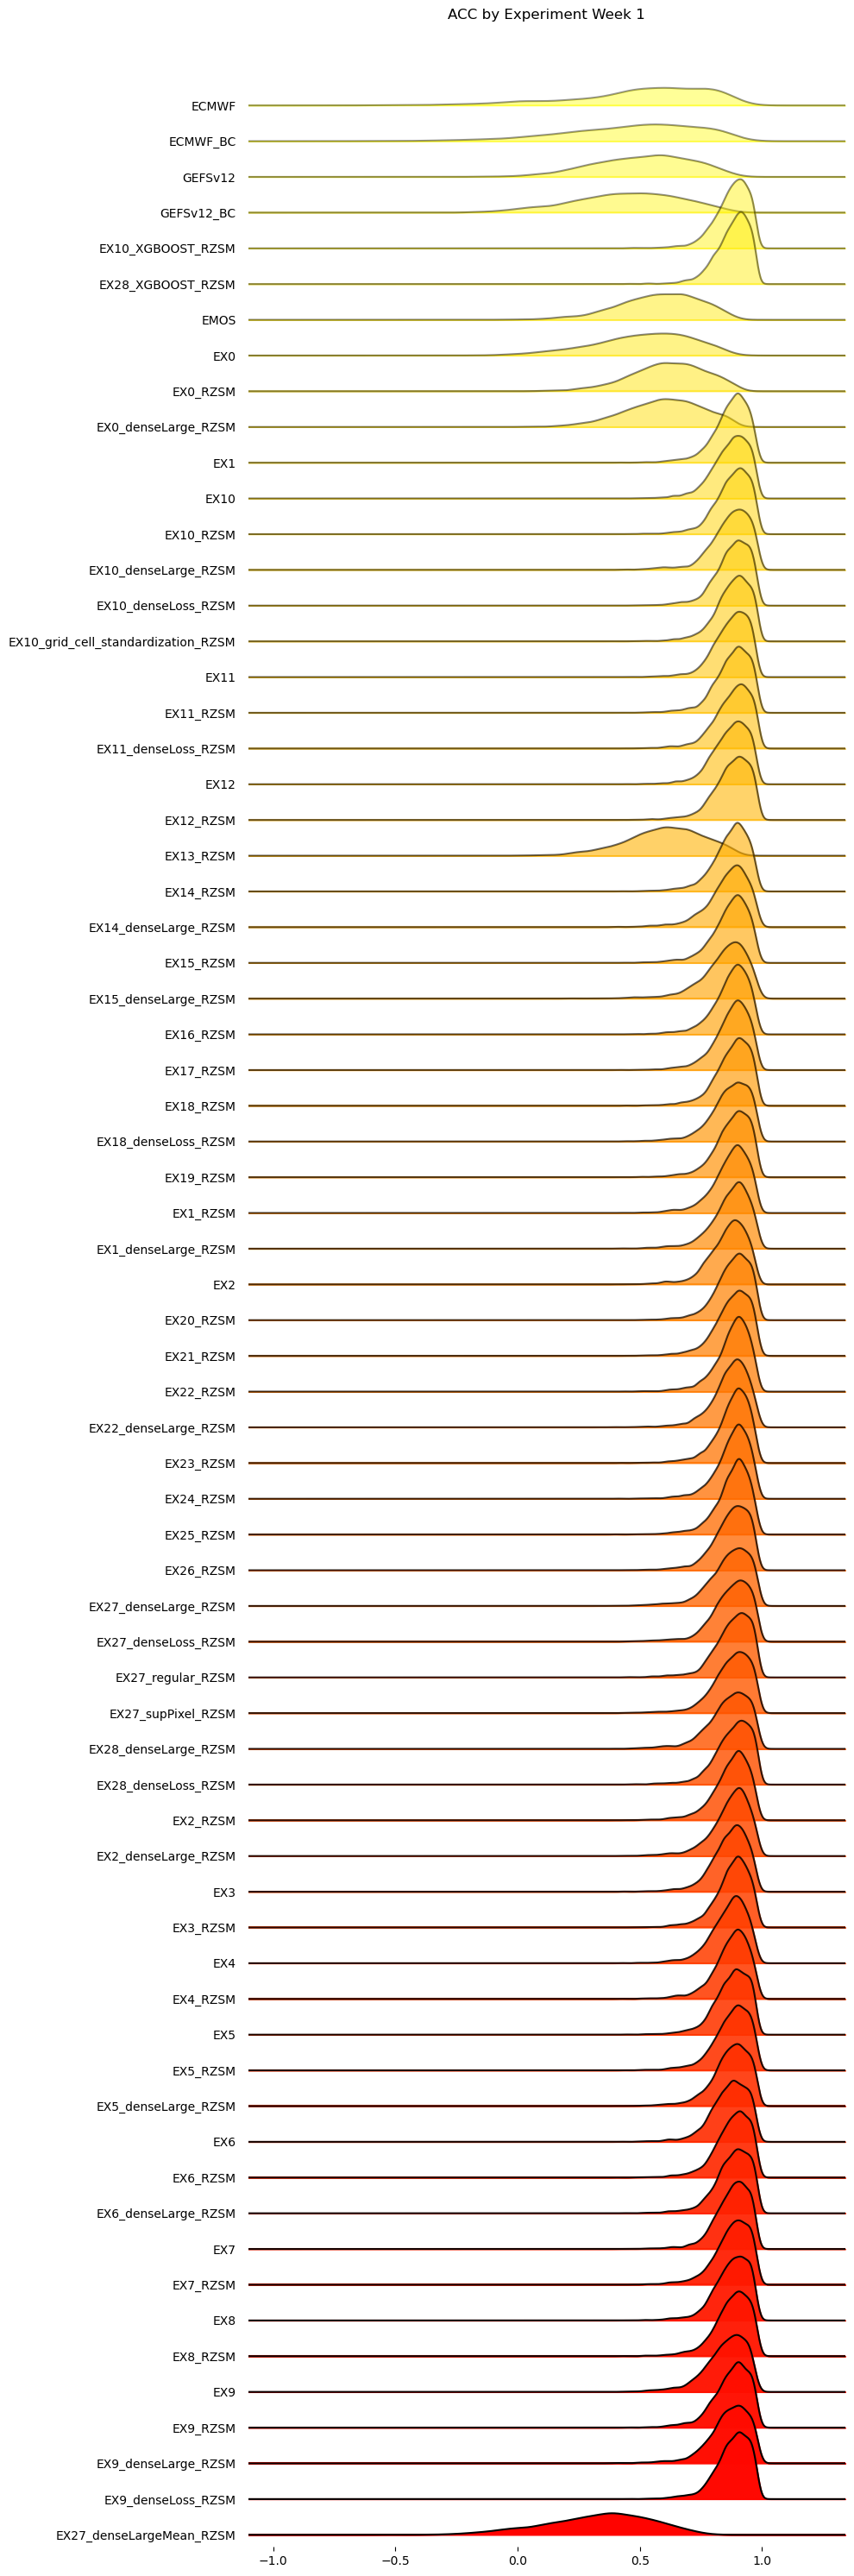

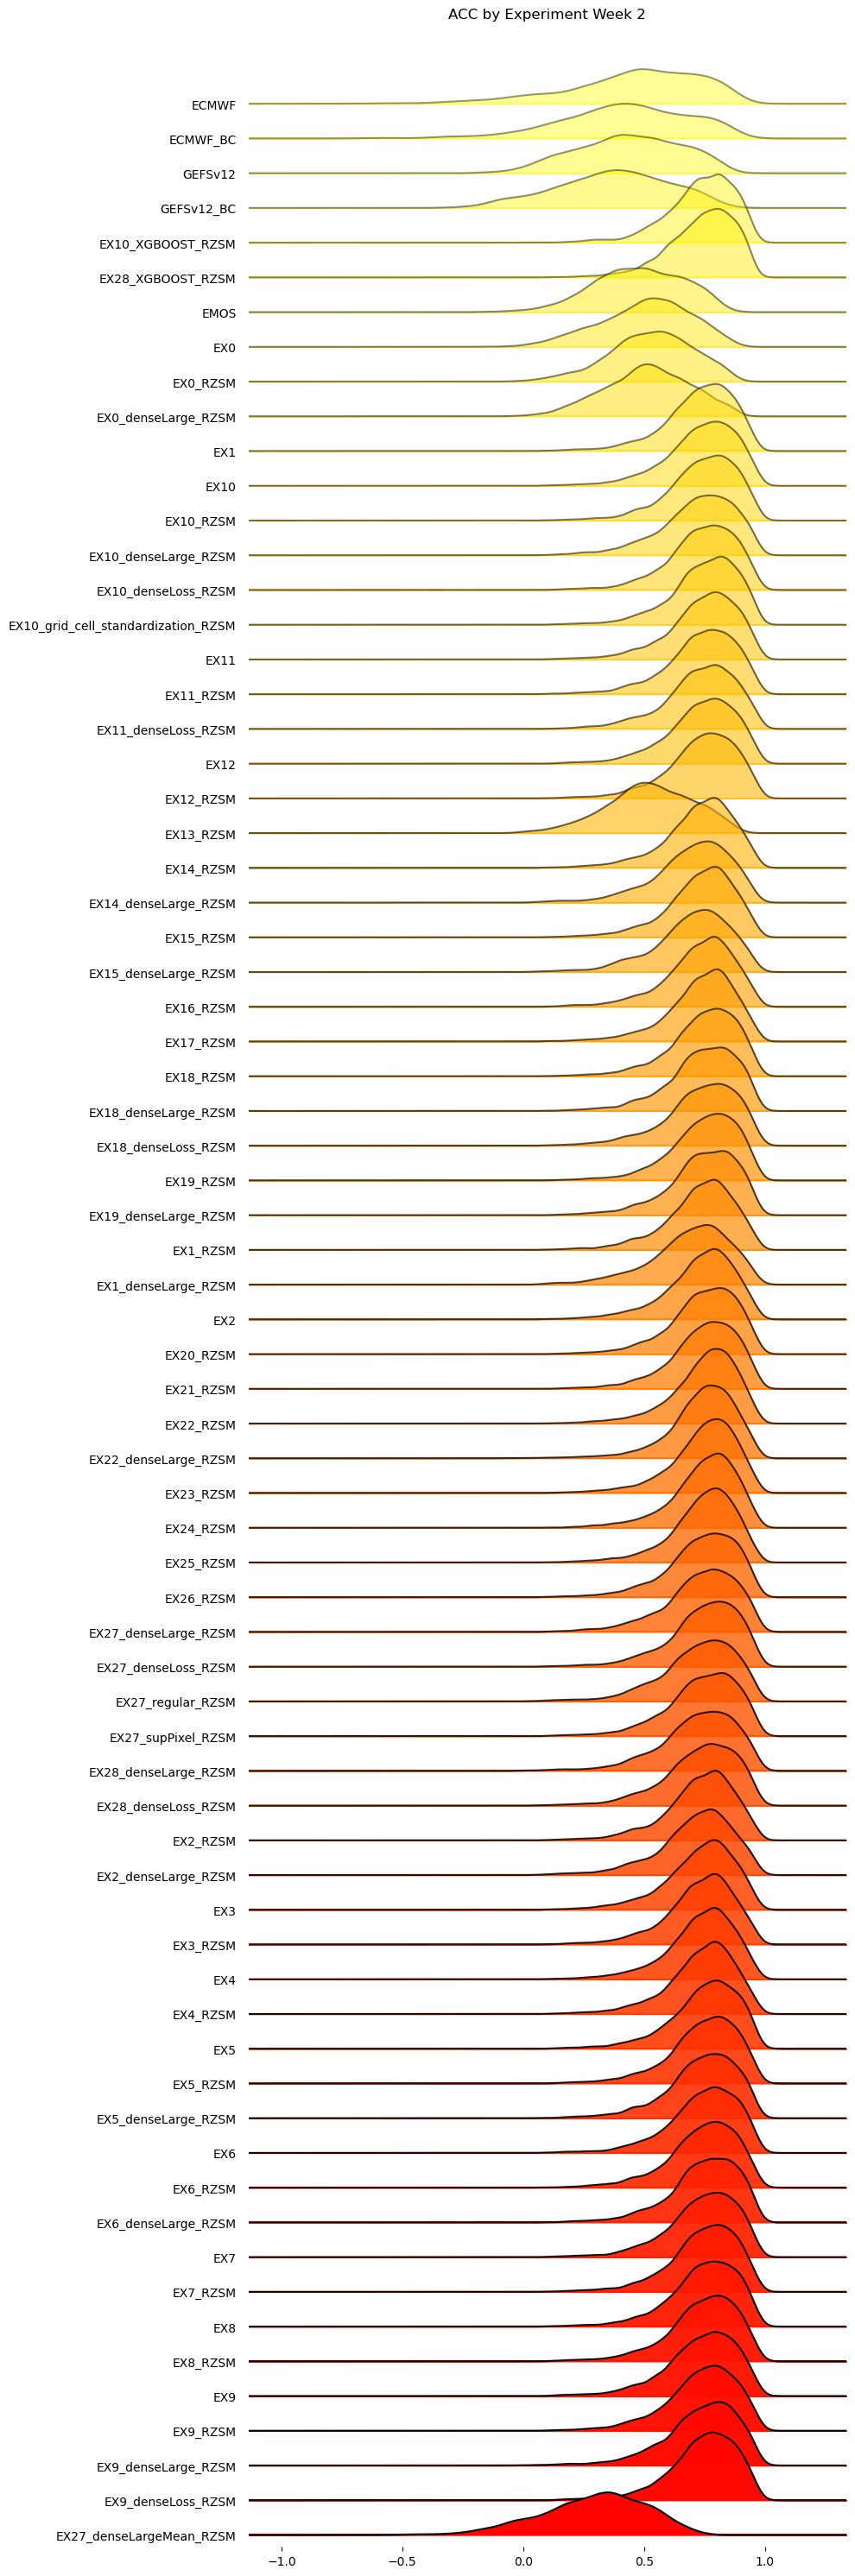

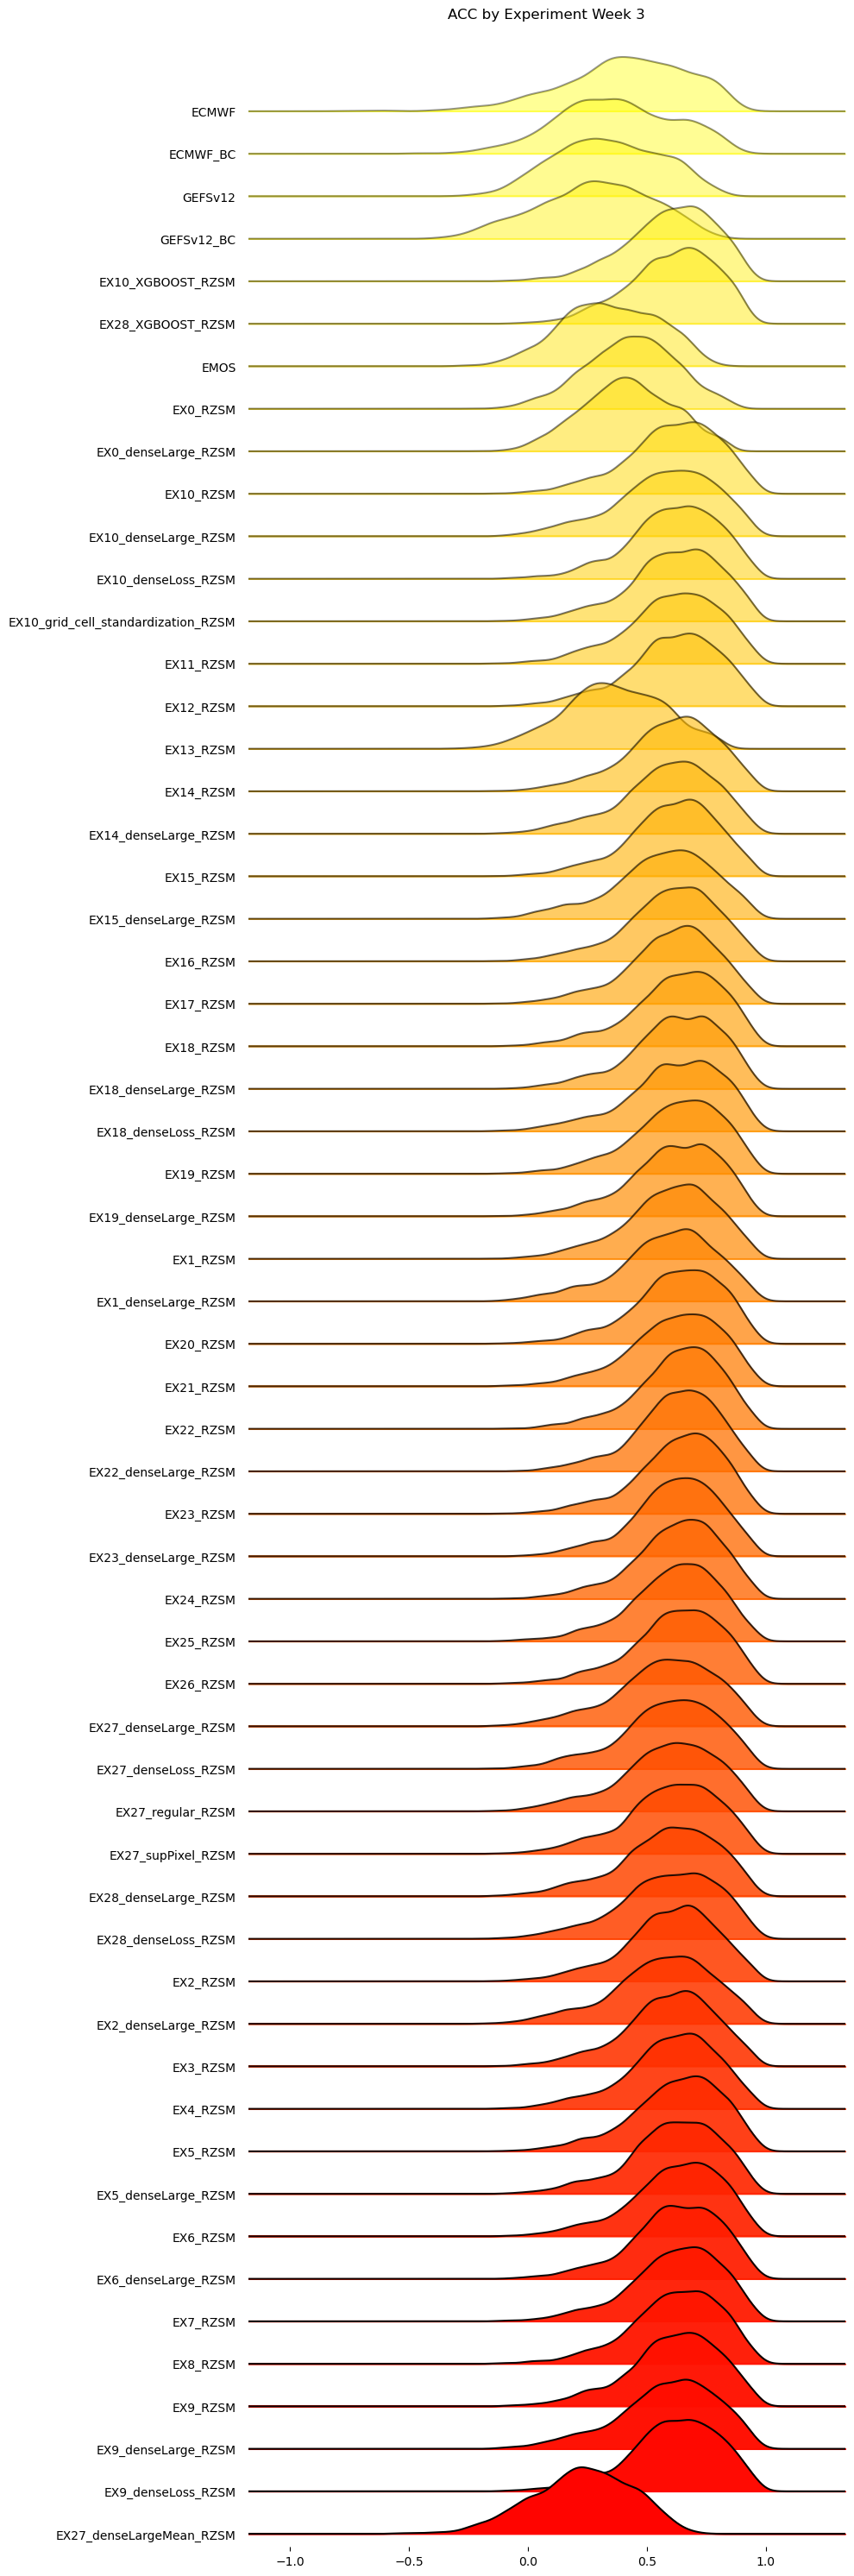

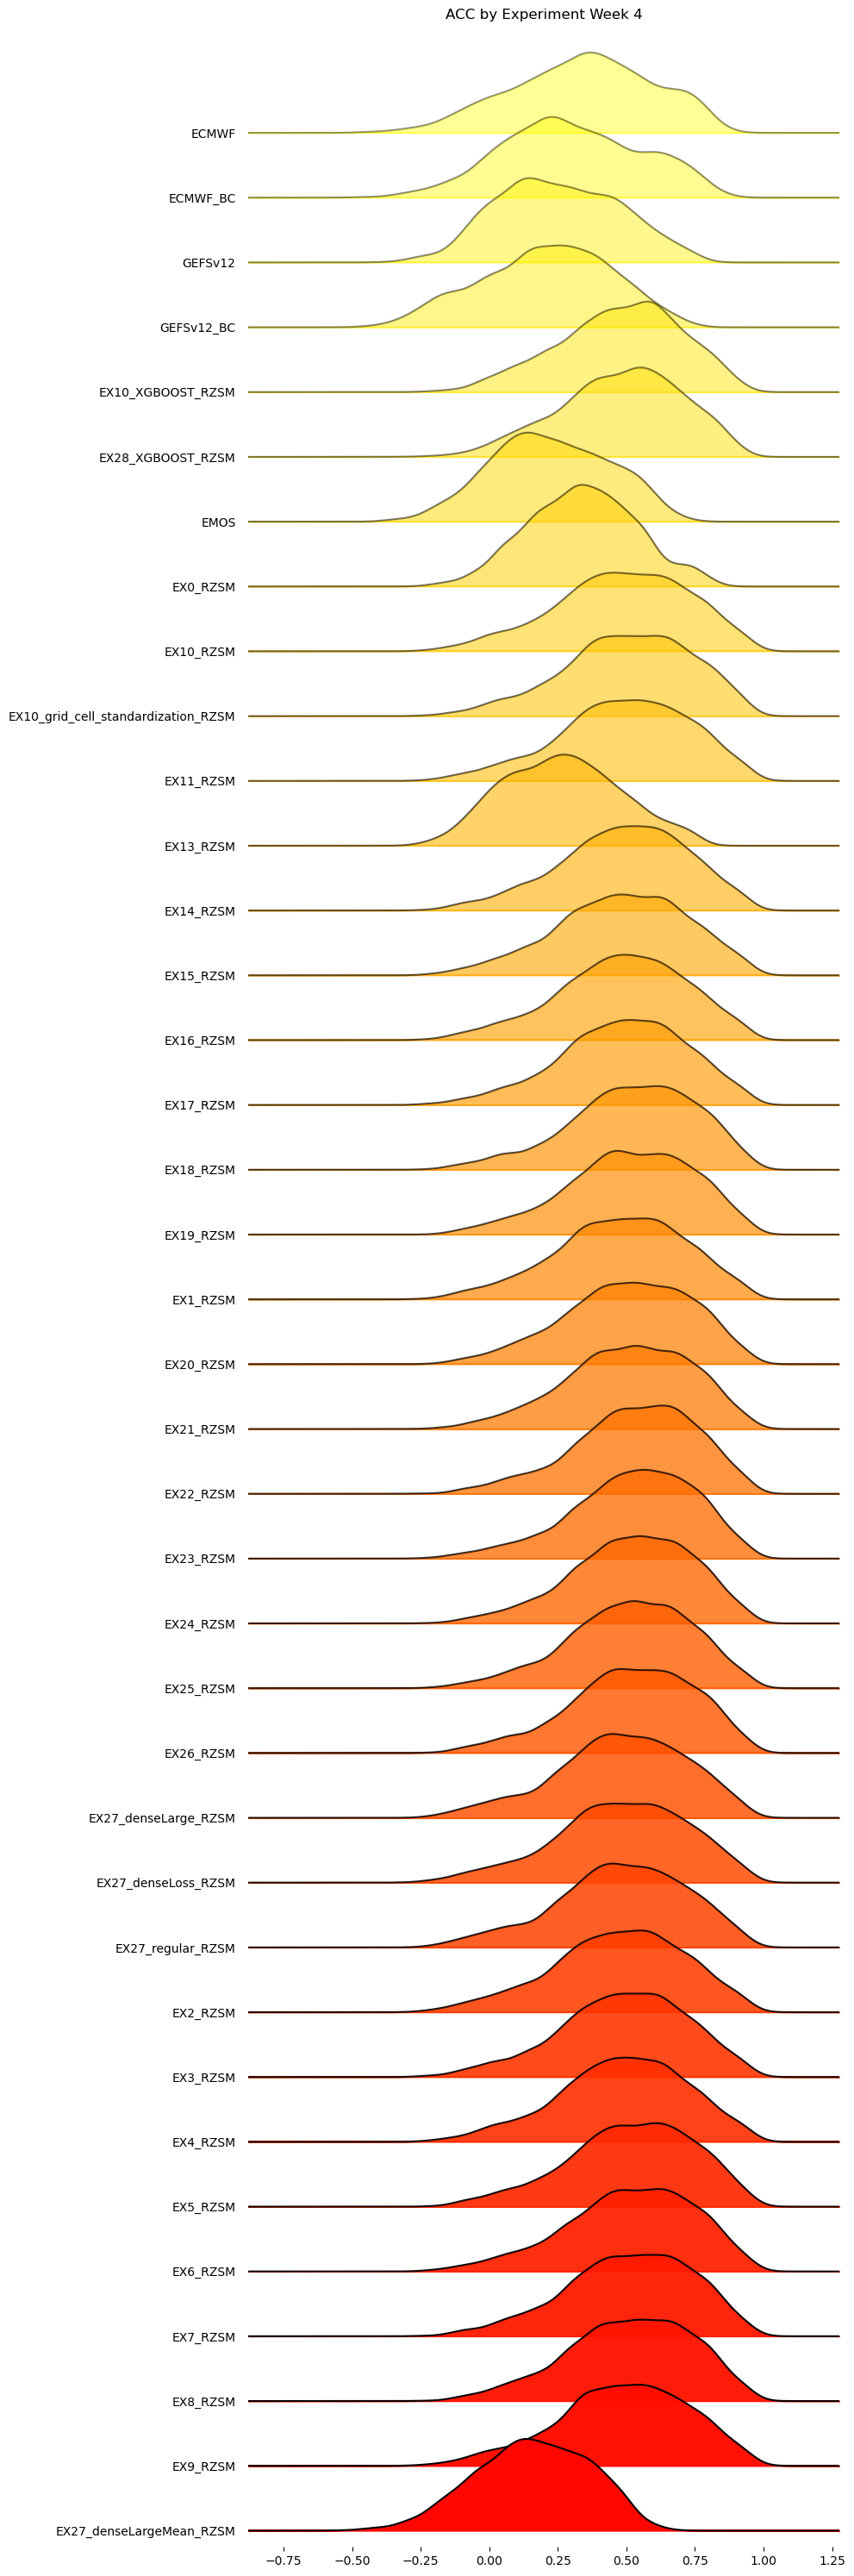

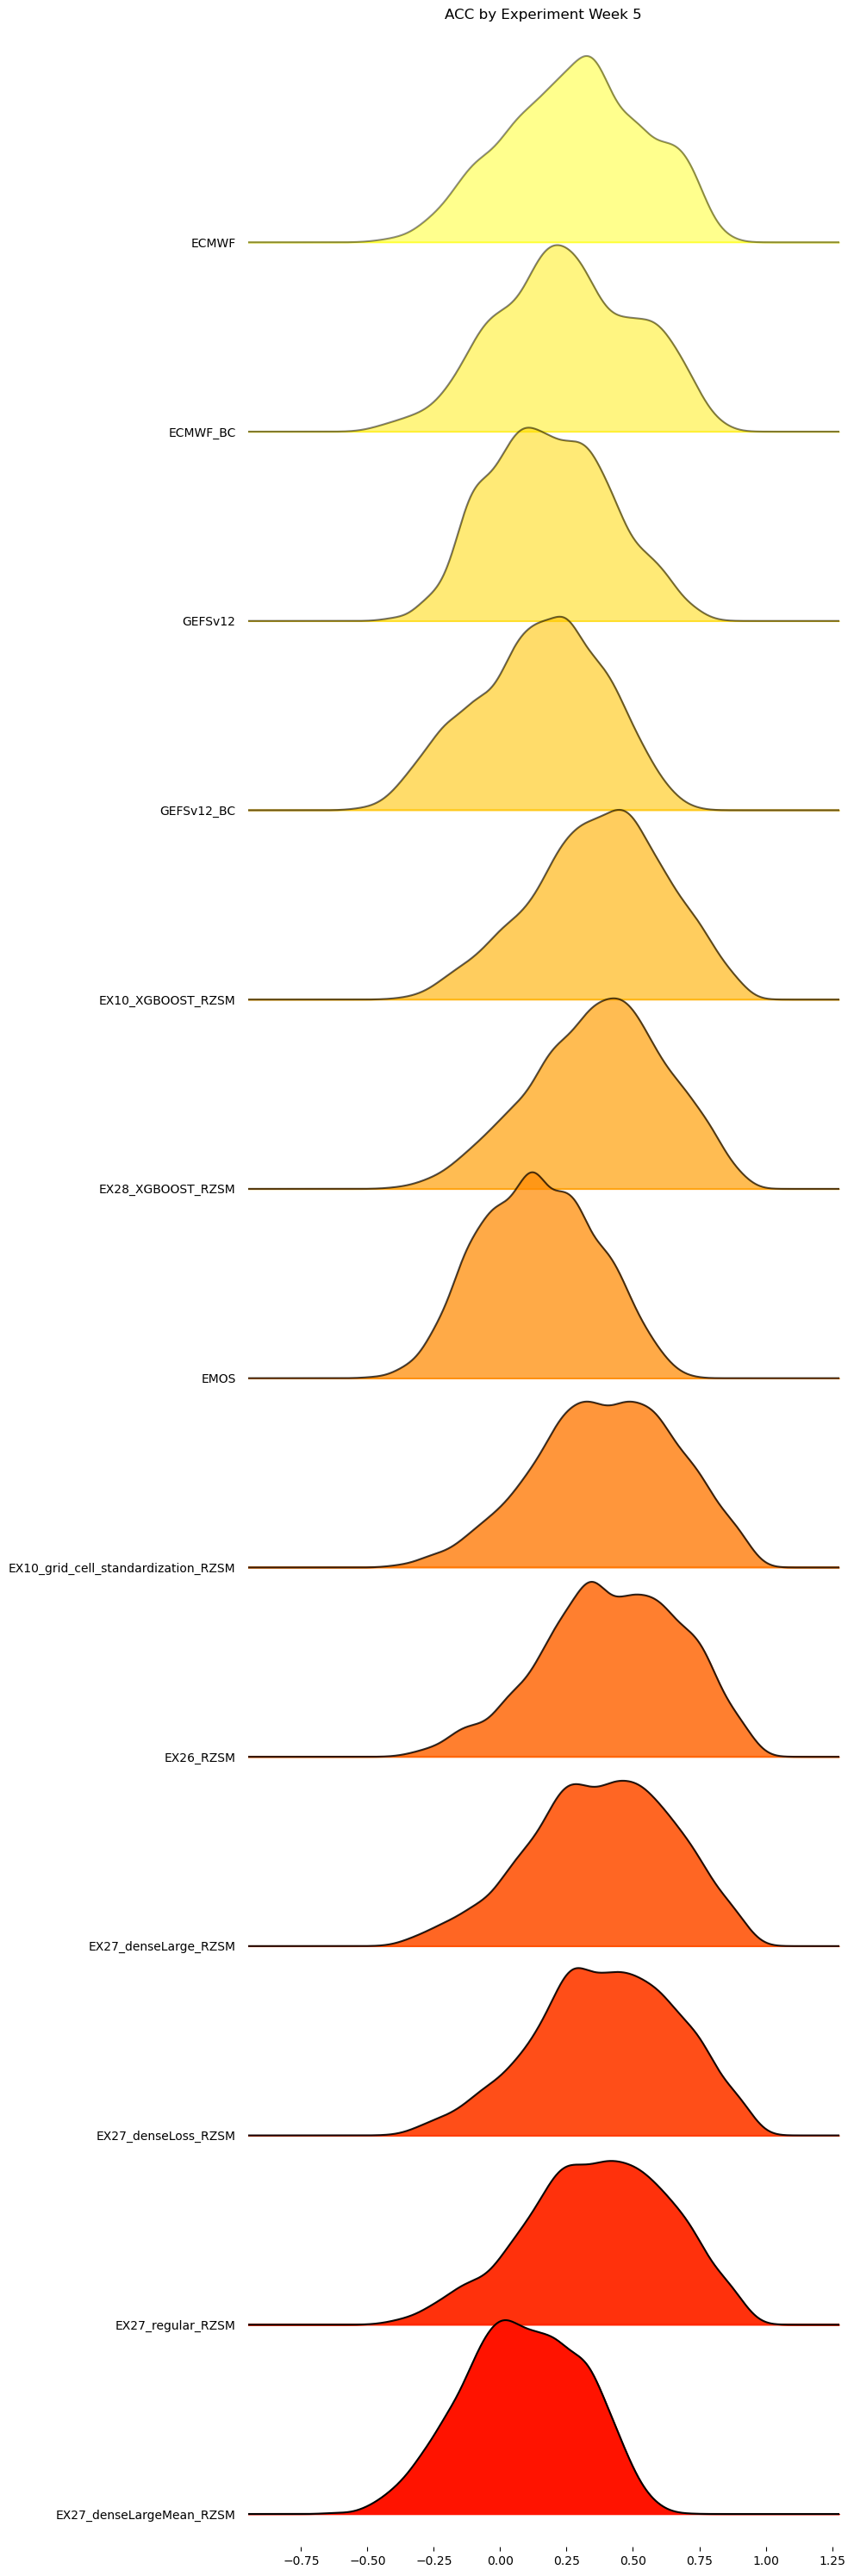

In [102]:
for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        ridgeplot_ACC_climpred_with_XGBOOST(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments='all')
    else:
        ridgeplot_ACC_climpred_only_UNET(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments='EX27_regular_RZSM')
    # ridgeplot_ACC_climpred(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments = 'EX27')

In [113]:
def evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end, unet_file):

    #Test 
    # week_lead=1
    # percentile_eval = 20

    #Save dir
    save_dir = f'Data/{region_name}/correct_anomaly_percentile_statistics'
    os.system(f'mkdir -p {save_dir}')

    save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats.npy'
    save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats.npy'
    save_xg = f'{save_dir}/Wk{week_lead}_xgboost_stats.npy'

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)

    obs_percent = obs_anom_percentile.sel(L=day_num).sel(M=0)
    obs_percent['95th_percentile'].shape #(104, 48, 96)

    #Get UNET prediction (single file)
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*EX27_denseLarge_RZSM*'))[0]

    test_name = unet_file.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
    save_unet = f'{save_dir}/Wk{week_lead}_unet_{test_name}_stats.npy'
    test =  verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
    test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
    test.shape

    #Now mask the input
    test_unet = np.where(mask_anom == 1,test,np.nan)

    final_perc_gefs = np.zeros(shape=(48,96,8)) #Adding 8 channels for the different anomaly spreads
    final_perc_gefs[:,:,:] = np.nan
    final_perc_ecmwf = final_perc_gefs.copy()
    final_perc_unet = final_perc_gefs.copy()
    
    
    #XGBoost
    #Load the XGBoost data
    if region_name == 'CONUS':
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))[0]
    
        # break
        #Still working here
        test_name = xgboost_files.split('testing_')[-1].split('.npy')[0]
        load_ = np.expand_dims(np.load(xgboost_files),-1)
        load_.shape
        load_ = np.where(load_ == 0,np.nan,load_)
        load_ =  verifications.reverse_min_max_scaling(load_, region_name, day_num)#We only want the last channel
        
        xg = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
        for j in range(11):
            xg[:,j,:,:,:] = load_
    
        xg = xg.squeeze()
        xg.shape
        final_perc_xg = final_perc_gefs.copy()
        x_vals = np.nanmean(xg,axis=1)
    else:
        x_vals = final_perc_gefs.copy()
        
    #Check if the predicted anomaly is below each threshold

    file = baseline_anomaly
    file.RZSM.shape
    out_check_gefs_base = np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads
    
    out_check_gefs_base[:,:,:,:] = np.nan
    out_check_ecmwf_base = out_check_gefs_base.copy()
    out_check_unet = out_check_gefs_base.copy()
    out_check_xg = out_check_gefs_base.copy()


    
    #Test
    # idx = 0
    # mx = 0
    # ix = 10
    # iy =10 #NEGATIVE ANOMALY VALUE
    # iy =5 #POSITIVE ANOMALY VALUE

    #Use np.where to find the values of the percentile

    #Take ensemble mean
    o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
    g_vals =  np.nanmean(gefs.RZSM[:,:,0,:,:].values,axis=1)
    e_vals =  np.nanmean(ecmwf.RZSM[:,:,0,:,:].values,axis=1)
    u_vals = np.nanmean(test_unet,axis=1)
    

    u_vals.shape
    x_vals.shape

    def check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
        perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
        def find_percentage(perc_,o_vals,fcst):
            correct =  np.count_nonzero(~np.isnan(np.where((o_vals<perc_)&(fcst<perc_),1,np.nan)),axis=0)
            correct.shape #(104, 48, 96)
            incorrect =  np.count_nonzero(~np.isnan(np.where((o_vals<perc_)&(fcst>perc_),2,np.nan)),axis=0)
            return(correct/(correct + incorrect))

        g_perc = find_percentage(perc_,o_vals,g_vals)
        g_perc.shape
        e_perc = find_percentage(perc_,o_vals,e_vals)
        u_perc = find_percentage(perc_,o_vals,u_vals)
        x_perc = find_percentage(perc_,o_vals,x_vals)
        return(g_perc,e_perc,u_perc,x_perc)

    for idx,percentile_num in enumerate([5,10,20,33]):
        final_perc_gefs[:,:,idx], final_perc_ecmwf[:,:,idx], final_perc_unet[:,:,idx],final_perc_xg[:,:,idx] = check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)



    
    def check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
        perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
        def find_percentage(perc_,o_vals,fcst):
            correct =  np.count_nonzero(~np.isnan(np.where((o_vals>perc_)&(fcst>perc_),1,np.nan)),axis=0)
            correct.shape #(104, 48, 96)
            incorrect =  np.count_nonzero(~np.isnan(np.where((o_vals>perc_)&(fcst<perc_),2,np.nan)),axis=0)
            return(correct/(correct + incorrect))

        g_perc = find_percentage(perc_,o_vals,g_vals)
        g_perc.shape
        e_perc = find_percentage(perc_,o_vals,e_vals)
        u_perc = find_percentage(perc_,o_vals,u_vals)
        x_perc = find_percentage(perc_,o_vals,x_vals)
        
        return(g_perc,e_perc,u_perc,x_perc)
    
    for idx,percentile_num in enumerate([66,80,90,95]):
        '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
        final_perc_gefs[:,:,idx+4], final_perc_ecmwf[:,:,idx+4], final_perc_unet[:,:,idx+4], final_perc_xg[:,:,idx+4] = check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)


    #Save files for later use
    np.save(save_ecmwf,final_perc_ecmwf)
    np.save(save_gefs, final_perc_gefs)
    np.save(save_unet, final_perc_unet)
    np.save(save_xg, final_perc_xg)



In [139]:

for week_lead in [3,4,5]:
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    unet_files = [i for i in unet_files if 'final_mean_ensemble' not in i]
    unet_files = [i for i in unet_files if 'mean' not in i]
    for unet_file in unet_files:
        evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end,unet_file)

Loading observation and baseline anomaly files


/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/165448863.py:62: RuntimeWarning: Mean of empty slice
  x_vals = np.nanmean(xg,axis=1)
/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/165448863.py:87: RuntimeWarning: Mean of empty slice
  o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/165448863.py:90: RuntimeWarning: Mean of empty slice
  u_vals = np.nanmean(test_unet,axis=1)
/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/165448863.py:103: RuntimeWarning: invalid value encountered in divide
  return(correct/(correct + incorrect))
/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/165448863.py:125: RuntimeWarning: invalid value encountered in divide
  return(correct/(correct + incorrect))


Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading obser

In [ ]:
# def setup_percentiles_for_ROC_plot(week_lead, region_name, test_start, test_end):

#     #Test 
#     # week_lead=1
#     # percentile_eval = 20

#     #Save dir
#     save_dir = f'Data/{region_name}/correct_anomaly_percentile_statistics'
#     os.system(f'mkdir -p {save_dir}')

#     save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats_ROC.npy'
#     save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats_ROC.npy'
#     save_unet = f'{save_dir}/Wk{week_lead}_unet_stats_ROC.npy'
#     save_xg = f'{save_dir}/Wk{week_lead}_xgboost_stats_ROC.npy'
#     save_obs_binary = f'{save_dir}/Wk{week_lead}_obs_binary_stats_ROC.npy'

#     if (os.path.exists(save_ecmwf) and os.path.exists(save_ecmwf) and os.path.exists(save_ecmwf) and os.path.exists(save_xg) and os.path.exists(save_obs_binary)):
#         pass
#     else:
    
#         day_num = (week_lead*7) -1
        
#         print('Loading observation and baseline anomaly files')
#         obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only= open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                         test_start = test_start, test_end = test_end)
#         #Test 
#         gefs = baseline_anomaly
#         ecmwf = baseline_ecmwf
#         obs = obs_anomaly_SubX_format
    
        
#         obs_percent = obs_anom_percentile.sel(L=day_num).sel(M=0)
#         obs_percent['95th_percentile'].shape #(104, 48, 96)
    
#         #Get UNET prediction (single file)
#         #Now for all predictions from UNET, make the ACC
#         unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*EX27_regular_RZSM*'))[0]
        
#         test_name = unet_files.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
#         test =  verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#         test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#         test.shape
    
#         #Now mask the input
#         test_unet = np.where(mask_anom == 1,test,np.nan)

#         #XGBoost
#         #Load the XGBoost data
#         xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))[0]

#         # break
#         #Still working here
#         test_name = xgboost_files.split('testing_')[-1].split('.npy')[0]
#         load_ = np.expand_dims(np.load(xgboost_files),-1)
#         load_.shape
#         load_ = np.where(load_ == 0,np.nan,load_)
#         load_ =  verifications.reverse_min_max_scaling(load_, region_name, day_num)#We only want the last channel
        
#         xg = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
#         for j in range(11):
#             xg[:,j,:,:,:] = load_

#         xg = xg.squeeze()
#         xg.shape
        



        
        
#         #Check if the predicted anomaly is below each threshold
    
#         file = baseline_anomaly
#         file.RZSM.shape
#         out_check_gefs_base = np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads
        
#         out_check_gefs_base[:,:,:,:] = np.nan
#         out_check_ecmwf_base = out_check_gefs_base.copy()
#         out_check_unet = out_check_gefs_base.copy()
#         out_check_xg = out_check_gefs_base.copy()
        
#         obs_binary_out =np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads

#         final_perc_gefs = np.zeros(shape=(104,48,96,8)) #Adding 8 channels for the different anomaly spreads
#         final_perc_gefs[:,:,:] = np.nan
#         final_perc_ecmwf = final_perc_gefs.copy()
#         final_perc_unet = final_perc_gefs.copy()
#         final_perc_xg = final_perc_gefs.copy()
        
#         #Test
#         # idx = 0
#         # mx = 0
#         # ix = 10
#         # iy =10 #NEGATIVE ANOMALY VALUE
#         # iy =5 #POSITIVE ANOMALY VALUE

#         #Use np.where to find the values of the percentile

#         #Take ensemble mean
#         # o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
#         # g_vals =  np.nanmean(gefs.RZSM[:,:,0,:,:].values,axis=1)
#         # e_vals =  np.nanmean(ecmwf.RZSM[:,:,0,:,:].values,axis=1)
#         # u_vals = np.nanmean(test_unet,axis=1)
#         # x_vals = np.nanmean(xg,axis=1)

#         #Keep all models the same
#         o_vals = obs.RZSM[:,:,0,:,:].values
#         g_vals =  gefs.RZSM[:,:,0,:,:].values
#         e_vals =  ecmwf.RZSM[:,:,0,:,:].values
#         u_vals = test_unet
#         x_vals = xg

#         u_vals.shape
#         x_vals.shape

#         def check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
#             perc_= obs_percent[f'{percentile_num}th_percentile'].values
#             #Just expand the percentiles to match the data
#             perc_expanded = np.zeros(shape=(104,11,48,96))
#             perc_expanded[:,:,:,:] = np.nan
#             for i in range(11):
#                 perc_expanded[:,i,:,:]  = perc_
            
            
#             def find_percentage(perc_expanded,o_vals,fcst):
#                 correct =  np.where((o_vals<perc_expanded)&(fcst<perc_expanded),1,0)
#                 obs_binary = np.where((o_vals<perc_expanded),1,0)
#                 '''Take the mean to find the probability of correct'''
#                 correct = np.nanmean(correct,axis=1)
#                 correct.shape #(104, 48, 96)
#                 #Now mask the input of CONUS/region
#                 correct = np.where(mask_anom == 1,correct,np.nan)

#                 return(correct,obs_binary)

#             g_perc,obs_binary = find_percentage(perc_expanded,o_vals,g_vals)
#             g_perc.shape
#             e_perc,obs_binary = find_percentage(perc_expanded,o_vals,e_vals)
#             u_perc,obs_binary  = find_percentage(perc_expanded,o_vals,u_vals)
#             x_perc,obs_binary  = find_percentage(perc_expanded,o_vals,x_vals)
#             return(g_perc,e_perc,u_perc,x_perc,obs_binary )

#         for idx,percentile_num in enumerate([5,10,20,33]):
#             final_perc_gefs[:,:,:,idx], final_perc_ecmwf[:,:,:,idx], final_perc_unet[:,:,:,idx],final_perc_xg[:,:,:,idx],obs_binary_out[:,:,:,:,idx] = check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)



        
#         def check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
#             perc_= obs_percent[f'{percentile_num}th_percentile'].values
#             #Just expand the percentiles to match the data
#             perc_expanded = np.zeros(shape=(104,11,48,96))

            
#             perc_expanded[:,:,:,:] = np.nan
#             for i in range(11):
#                 perc_expanded[:,i,:,:]  = perc_
            
            
#             def find_percentage(perc_expanded,o_vals,fcst):
#                 correct =  np.where((o_vals>perc_expanded)&(fcst>perc_expanded),1,0)
#                 '''Take the mean to find the probability of correct'''
#                 obs_binary = np.where((o_vals>perc_expanded),1,0)
                
#                 correct = np.nanmean(correct,axis=1)
#                 correct.shape #(104, 48, 96)
#                 #Now mask the input of CONUS/region
#                 correct = np.where(mask_anom == 1,correct,np.nan)

#                 return(correct,obs_binary )

#             g_perc,obs_binary  = find_percentage(perc_expanded,o_vals,g_vals)
#             g_perc.shape
#             e_perc,obs_binary  = find_percentage(perc_expanded,o_vals,e_vals)
#             u_perc,obs_binary  = find_percentage(perc_expanded,o_vals,u_vals)
#             x_perc,obs_binary  = find_percentage(perc_expanded,o_vals,x_vals)
            
#             return(g_perc,e_perc,u_perc,x_perc,obs_binary )
        
#         for idx,percentile_num in enumerate([66,80,90,95]):
#             '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
#             final_perc_gefs[:,:,:,idx+4], final_perc_ecmwf[:,:,:,idx+4], final_perc_unet[:,:,:,idx+4], final_perc_xg[:,:,:,idx+4],obs_binary_out[:,:,:,:,idx+4] = check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)


#         #Just save the obs_binary_out as the (init,lat,lon)
#         obs_binary_out = np.nanmean(obs_binary_out,axis=1)
        
#         #Save files for later use
#         np.save(save_ecmwf,final_perc_ecmwf)
#         np.save(save_gefs, final_perc_gefs)
#         np.save(save_unet, final_perc_unet)
#         np.save(save_xg, final_perc_xg)
#         np.save(save_obs_binary, obs_binary_out)


In [ ]:
# for week_lead in [1,2,3,4,5]:
#     setup_percentiles_for_ROC_plot(week_lead, region_name, test_start, test_end)

### Reason why the plots don't have a curve:

### Threshold Granularity: If the model outputs have limited granularity (i.e., a small number of unique score values), the ROC curve can appear as a series of straight lines, as each unique value creates a step change in the TPR and FPR.

In [ ]:

# '''CREATE a ROC figure for classification below the 20th percentile'''

# '''Only for 20th percentile'''
# percentile = 5

# if percentile == 20:
#     idx = 2
# elif percentile == 10:
#     idx = 1
# elif percentile == 5:
#     idx = 0
# elif percentile == 33:
#     idx = 3


# #where files are saved
# dir_ = f'Data/{region_name}/correct_anomaly_percentile_statistics'

# save_dir = f'Outputs/ROC/{region_name}'
# os.system(f'mkdir -p {save_dir}')

# percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values

# for week_lead in [3,4,5]:
#     # break
#     save_ecmwf = f'{dir_}/Wk{week_lead}_ecmwf_stats_ROC.npy'
#     save_gefs = f'{dir_}/Wk{week_lead}_gefs_stats_ROC.npy'
#     save_unet = f'{dir_}/Wk{week_lead}_unet_stats_ROC.npy'
#     save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_ROC.npy'
#     obs_binary = np.load(f'{dir_}/Wk{week_lead}_obs_binary_stats_ROC.npy')
    

#     num_regions = 6
#     num_models = 4
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Different colors for each region
    
#     fig, axes = plt.subplots(1, num_models, figsize=(15, 5), dpi=300) 
#     # axs = axes.flatten()
    
#     ax_start = 0
#     for ref_name, ref_file in zip(['GEFSv12', 'ECMWF','UNET', 'XGBoost'],[save_gefs,save_ecmwf, save_unet, save_xg]):
#         ax = axes[ax_start]
        
#         # Placeholder for ROC curve data
#         fpr = {}
#         tpr = {}
#         roc_auc = {}
        
#         # break
#         reforecast = np.load(ref_file)
#         reforecast.shape
#         ref_subset = reforecast[:,:,:,idx]
#         ref_subset.shape

#         obs_subset_binary = obs_binary[:,:,:,idx]
        
#         for region_num,name in CONUS_region_names.items():
#             # break
#             region_subset = np.where(region_mask==region_num,ref_subset,np.nan)
#             obs_region_subset = np.where(region_mask==region_num,obs_subset_binary,np.nan)
            
#             predicted_probs_flat = region_subset.flatten()
#             observed_events_flat = obs_region_subset.flatten()

#             #Remove nans
#             mask_nan =~np.isnan(observed_events_flat)
#             observed_events_flat = observed_events_flat[mask_nan]
#             predicted_probs_flat = predicted_probs_flat[mask_nan]
#             #Set a threshold where at least 50 percent of the models must agree
#             predicted_probs_flat = [0 if i <0.5 else i for i in predicted_probs_flat]
            
#             #Make a random probability sample
#             # predicted_probs_flat = np.random.uniform(size=len(observed_events_flat))

#             fpr[name], tpr[name], _ = roc_curve(observed_events_flat, predicted_probs_flat,pos_label=1)
#             roc_auc[name] = auc(fpr[name], tpr[name])

#         colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(CONUS_region_names.values()))))
#         for k,name in CONUS_region_names.items():
#             # break
#             ax.plot(fpr[name], tpr[name], color=next(colors), lw=2, label=f'{name} (area = {roc_auc[name]:.2f})')
#             # plt.show()
#         ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#         # ax.xlim([0.0, 1.0])
#         # ax.ylim([0.0, 1.05])
#         ax.set_xlabel('False Positive Rate')
#         ax.set_ylabel('True Positive Rate')
#         ax.set_title(f'{ref_name}')
#         ax.legend(loc="lower right")
#         ax_start+=1
        

#     plt.tight_layout()
#     plt.suptitle(f'Week {week_lead}')
#     plt.savefig(f'{save_dir}/Wk{week_lead}_ROC_{percentile}th_percentile.png')
                        




In [ ]:
# #Plot a single grid cell ROC

# lat,lon = 10,10

# reforecast = np.load(save_unet)
# reforecast.shape


# fig, axs = plt.subplots(10,5,figsize=(10,20))
# axs = axs.flatten()

# count=0
# for lon in np.arange(20,25):
#     for lat in np.arange(10,20):
        
#         ref_subset = reforecast[:,lat,lon,idx]
#         ref_subset.shape

#         if np.count_nonzero(np.isnan(ref_subset)) == 104:
#             pass
#         else:
        
#             obs_subset_binary = obs_binary[:,lat,lon,idx]
            
#             ref_subset.shape
            
#             predicted_probs_flat = ref_subset.flatten()
#             observed_events_flat = obs_subset_binary.flatten()
            
#             # Calculate ROC curve
#             fpr, tpr, thresholds = roc_curve(observed_events_flat, predicted_probs_flat)
            
#             # Calculate AUC
#             roc_auc = auc(fpr, tpr)


#             axs[count].plot(fpr, tpr)
#             axs[count].plot([0, 1], [0, 1], 'k--')
#             axs[count].set_title(f'Lat: {lat} Lon: {lon}')
#             axs[count].set_xlabel('False Positive Rate')
#             axs[count].set_ylabel('True Positive Rate')
#             axs[count].legend(loc="lower right")
#             count +=1

# plt.tight_layout()


In [177]:
def setup_binary_for_hit_rate_with_ensemble_mean(week_lead, region_name, test_start, test_end, unet_file):

    #Test 
    # week_lead=1
    # percentile_eval = 20

    #Save dir
    save_dir = f'Data/{region_name}/correct_anomaly_percentile_statistics'
    os.system(f'mkdir -p {save_dir}')

    save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats_TP_FP_ensemble_mean.npy'
    save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats_TP_FP_ensemble_mean.npy'
    save_xg = f'{save_dir}/Wk{week_lead}_xgboost_stats_TP_FP_ensemble_mean.npy'
    save_obs_binary = f'{save_dir}/Wk{week_lead}_obs_stats_TP_FP_ensemble_mean.npy'

    day_num = (week_lead*7) -1
        
    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)
    
    obs_percent = obs_anom_percentile.sel(L=day_num).sel(M=0)
    obs_percent['95th_percentile'].shape #(104, 48, 96)


    file = baseline_anomaly
    file.RZSM.shape
    out_check_gefs_base = np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads
    
    out_check_gefs_base[:,:,:,:] = np.nan
    out_check_ecmwf_base = out_check_gefs_base.copy()
    out_check_unet = out_check_gefs_base.copy()
    
    
    obs_binary_out =np.zeros(shape=(104,48,96,8)) #Adding 8 channels for the different anomaly spreads

    final_perc_gefs = np.zeros(shape=(104,48,96,8)) #Adding 8 channels for the different anomaly spreads
    final_perc_gefs[:,:,:] = np.nan
    final_perc_ecmwf = final_perc_gefs.copy()
    final_perc_unet = final_perc_gefs.copy()
    
    

    test_name = unet_file.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
    save_unet = f'{save_dir}/Wk{week_lead}_unet_stats_{test_name}_TP_FP_ensemble_mean.npy'
    
    test =  verifications.reverse_min_max_scaling(np.load(unet_file), region_name, day_num)[2,:,:,:,0] #We only want the last channel
    test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
    test.shape

    #Now mask the input
    test_unet = np.where(mask_anom == 1,test,np.nan)

    #XGBoost
    #Load the XGBoost data
    if region_name == 'CONUS':
        out_check_xg = out_check_gefs_base.copy()
        final_perc_xg = final_perc_gefs.copy()
        
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))[0]
    
        # break
        #Still working here
        test_name = xgboost_files.split('testing_')[-1].split('.npy')[0]
        load_ = np.expand_dims(np.load(xgboost_files),-1)
        load_.shape
        load_ = np.where(load_ == 0,np.nan,load_)
        load_ =  verifications.reverse_min_max_scaling(load_, region_name, day_num)#We only want the last channel
        
        xg = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
        for j in range(11):
            xg[:,j,:,:,:] = load_
    
        xg = xg.squeeze()
        xg.shape
        x_vals = np.nanmean(xg,axis=1)
    else:
        x_vals = out_check_gefs_base.copy()
    #Check if the predicted anomaly is below each threshold


    
    #Test
    # idx = 0
    # mx = 0
    # ix = 10
    # iy =10 #NEGATIVE ANOMALY VALUE
    # iy =5 #POSITIVE ANOMALY VALUE

    #Use np.where to find the values of the percentile

    #Take ensemble mean
    o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
    g_vals =  np.nanmean(gefs.RZSM[:,:,0,:,:].values,axis=1)
    e_vals =  np.nanmean(ecmwf.RZSM[:,:,0,:,:].values,axis=1)
    u_vals = np.nanmean(test_unet,axis=1)
    

    #Keep all models the same
    # o_vals = obs.RZSM[:,:,0,:,:].values
    # g_vals =  gefs.RZSM[:,:,0,:,:].values
    # e_vals =  ecmwf.RZSM[:,:,0,:,:].values
    # u_vals = test_unet
    # x_vals = xg

    u_vals.shape
    x_vals.shape

    def check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
        perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
        def find_percentage(perc_,o_vals,fcst):
            fcst =  np.where(fcst<perc_,1,0)
            obs_binary = np.where((o_vals<perc_),1,0)
            '''Take the mean to find the probability of correct'''
            fcst.shape #(104, 48, 96)
            #Now mask the input of CONUS/region
            fcst = np.where(mask_anom == 1,fcst,np.nan)
            obs_binary = np.where(mask_anom == 1,obs_binary,np.nan)

            return(fcst,obs_binary)

        g_perc,obs_binary = find_percentage(perc_,o_vals,g_vals)
        g_perc.shape
        e_perc,obs_binary = find_percentage(perc_,o_vals,e_vals)
        u_perc,obs_binary  = find_percentage(perc_,o_vals,u_vals)
        x_perc,obs_binary  = find_percentage(perc_,o_vals,x_vals)
        return(g_perc,e_perc,u_perc,x_perc,obs_binary )

    for idx,percentile_num in enumerate([5,10,20,33]):
        final_perc_gefs[:,:,:,idx], final_perc_ecmwf[:,:,:,idx], final_perc_unet[:,:,:,idx],final_perc_xg[:,:,:,idx],obs_binary_out[:,:,:,idx] = check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)



    
    def check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
        perc_= obs_percent[f'{percentile_num}th_percentile'].values
       
        def find_percentage(perc_,o_vals,fcst):
            fcst =  np.where(fcst>perc_,1,0)
            obs_binary = np.where((o_vals>perc_),1,0)
            '''Take the mean to find the probability of correct'''
            fcst.shape #(104, 48, 96)
            #Now mask the input of CONUS/region
            fcst = np.where(mask_anom == 1,fcst,np.nan)
            obs_binary = np.where(mask_anom == 1,obs_binary,np.nan)

            return(fcst,obs_binary)

        g_perc,obs_binary  = find_percentage(perc_,o_vals,g_vals)
        g_perc.shape
        e_perc,obs_binary  = find_percentage(perc_,o_vals,e_vals)
        u_perc,obs_binary  = find_percentage(perc_,o_vals,u_vals)
        x_perc,obs_binary  = find_percentage(perc_,o_vals,x_vals)
        
        return(g_perc,e_perc,u_perc,x_perc,obs_binary )
    
    for idx,percentile_num in enumerate([66,80,90,95]):
        '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
        final_perc_gefs[:,:,:,idx+4], final_perc_ecmwf[:,:,:,idx+4], final_perc_unet[:,:,:,idx+4], final_perc_xg[:,:,:,idx+4],obs_binary_out[:,:,:,idx+4] = check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)

    
    #Save files for later use
    np.save(save_ecmwf,final_perc_ecmwf)
    np.save(save_gefs, final_perc_gefs)
    np.save(save_unet, final_perc_unet)
    np.save(save_xg, final_perc_xg)
    np.save(save_obs_binary, obs_binary_out)


In [178]:
for week_lead in [1,2,3,4,5]:
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    unet_files = [i for i in unet_files if 'final_mean_ensemble' not in i]
    unet_files = [i for i in unet_files if 'mean' not in i]
    for unet_file in unet_files:
        setup_binary_for_hit_rate_with_ensemble_mean(week_lead, region_name, test_start, test_end, unet_file)

Loading observation and baseline anomaly files


/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/610786399.py:74: RuntimeWarning: Mean of empty slice
  x_vals = np.nanmean(xg,axis=1)
/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/610786399.py:91: RuntimeWarning: Mean of empty slice
  o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
/glade/derecho/scratch/klesinger/tmp/ipykernel_49634/610786399.py:94: RuntimeWarning: Mean of empty slice
  u_vals = np.nanmean(test_unet,axis=1)


Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading observation and baseline anomaly files
Loading obser

In [60]:
'''Plot hit rate by grid cell'''

'''CREATE a ROC figure for classification below the 20th percentile'''

'''Only for 20th percentile'''
percentile = 20

#where files are saved
dir_ = f'Data/{region_name}/correct_anomaly_percentile_statistics'

save_dir = f'Outputs/hit_rate_stats/{region_name}'
os.system(f'mkdir -p {save_dir}')

percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values


#First save all data
def return_data_by_percentile(percentile,unet_file):
    
    if percentile == 20:
        idPercentile = 2
    elif percentile == 10:
        idPercentile = 1
    elif percentile == 5:
        idPercentile = 0
    elif percentile == 33:
        idPercentile = 3

    hitRate = {}

    unet_file_name = unet_file.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
    
    for week_lead in [3,4,5]:
        hitRate[f'Week {week_lead}'] = {}
        
        # break
        save_ecmwf = f'{dir_}/Wk{week_lead}_ecmwf_stats_TP_FP_ensemble_mean.npy'
        save_gefs = f'{dir_}/Wk{week_lead}_gefs_stats_TP_FP_ensemble_mean.npy'
        save_unet = f'{dir_}/Wk{week_lead}_unet_stats_{unet_file_name}_TP_FP_ensemble_mean.npy'
        save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_TP_FP_ensemble_mean.npy'
        
        obs_binary = np.load(f'{dir_}/Wk{week_lead}_obs_stats_TP_FP_ensemble_mean.npy')
        obs_binary = obs_binary[:,:,:,idPercentile]
    
        ax_start = 0
        for ref_name, ref_file in zip(['GEFSv12', 'ECMWF',unet_file_name, 'XGBoost'],[save_gefs,save_ecmwf, save_unet, save_xg]):
            # break
            
            out_plot = np.zeros(shape=(48,96))
            # ax = axes[ax_start]
            
            # break
            reforecast = np.load(ref_file)
            reforecast.shape
            ref_subset = reforecast[:,:,:,idPercentile]
            ref_subset.shape
            
            for idX in range(obs_binary.shape[2]):
                for idy in range(obs_binary.shape[1]):
                    
                    observed_labels = obs_binary[:,idy,idX].flatten()
                    predicted_labels = ref_subset[:,idy,idX].flatten()
                    if np.all(np.isnan(observed_labels)):
                        out_plot[idy,idX] = np.nan
                    else:
                        #Create contingency table
                        # cm = confusion_matrix(observed_labels, predicted_labels) 
                        # accuracy = accuracy_score(observed_labels, predicted_labels) #Fraction of correct prediction
                        # precision = precision_score(observed_labels, predicted_labels,pos_label=1) #True Discovery Rate
                        recall = recall_score(observed_labels, predicted_labels,pos_label=1) #Hit Rate/ True positive rate
                        # f1 = f1_score(observed_labels, predicted_labels,pos_label=1) #harmonic mean of the precision and recall
                            
                        # tnr = recall_score(observed_labels, predicted_labels, pos_label = 0)
                        # fpr = 1 - tnr
        
                        out_plot[idy,idX] = recall
                        
            hitRate[f'Week {week_lead}'][ref_name] = out_plot
    
    return(hitRate, unet_file_name)
            




In [79]:
#Get the global maximum
# Flatten the nested dictionary to extract all values

def plot_by_percentile_for_hitRate(percentile):

    save_dir = f'Outputs/hit_rate/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    #Get the UNET test which have the most by week 5
    unet_files = sorted(glob(f'predictions/{region_name}/Wk5_testing/*'))
    unet_files = [i for i in unet_files if 'final_mean_ensemble' not in i]
    unet_files = [i for i in unet_files if 'mean' not in i]
    
    for unet_file in unet_files:
        # break
        hitRate_to_plot,unet_file_name = return_data_by_percentile(percentile=percentile, unet_file = unet_file)
    
        all_values = [value for inner_dict in hitRate_to_plot.values() for value in inner_dict.values()]
        
        max_ = []
        min_ = []
        for i in range(len(all_values)):
            max_.append(max(all_values[i][0]))
            min_.append(min(all_values[i][0]))
        
        
        global_max, global_min = max(max_), min(min_)
        
        cmap = 'bwr'
        
        fig, axs = plt.subplots(
            nrows = 3, ncols= 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300)
        
        axs = axs.flatten()
        
        lon = mask.X.values
        lat = mask.Y.values
        
        axs_start = 0
        for lead in hitRate_to_plot.keys():
            for model in hitRate_to_plot[lead].keys():
                data = hitRate_to_plot[lead][model]
                v = np.linspace(global_min, global_max, 20, endpoint=True)
        
                map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                              llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
                
                x, y = map(*np.meshgrid(lon, lat))
                # Adjust the text coordinates based on the actual data coordinates
        
                im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                                      transform=ccrs.PlateCarree(), cmap=cmap)
                
                gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                           linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                gl.xlabels_top = False
                gl.ylabels_right = False
                if lead != 1:
                    gl.ylabels_left = False
                gl.xformatter = LongitudeFormatter()
                gl.yformatter = LatitudeFormatter()
                axs[axs_start].coastlines()
                axs[axs_start].set_aspect('equal')  # this makes the plots better
                axs[axs_start].set_title(f'{model} {lead}',fontsize=8)
                axs_start+=1
        
        cbar_ax = fig.add_axes([0.05, -0.05, .9, .04])
        
        # Draw the colorbar
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
        plt.suptitle(f'Hit Rate ( <{percentile}th percentile ) ensemble mean', fontsize=30)
        plt.tight_layout()
        
        plt.savefig(f'{save_dir}/{unet_file_name}_hit_rate_{percentile}th_percentile.png',bbox_inches='tight')

    return(0)

In [ ]:
percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values

percentile_list = [20]

for percentile in percentile_list:
     plot_by_percentile_for_hitRate(percentile)

In [ ]:
def ACC_climpred_improvement_over_baseline(region_name, test_start, test_end):

    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files_multiple_leads(region_name=region_name, leads=[6,13,20,27,34], day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
   
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    '''Initialized in the persistence output for ACC is the actual skill of the forecast'''

    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_persist, gefs_na = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    gefs_acc = gefs_persist.sel(skill='initialized')
    
    #Use this new climatology analysis
    # na, gefs_climatology = verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(baseline_anomaly_climatology), verifications.rename_obs_for_climpred(obs_original))
    
    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_persist, ecmwf_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_acc = ecmwf_persist.sel(skill='initialized')
    
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = xr.where(ec_not_nan,gefs_acc,np.nan)


    #Now add EMOS results
    if region_name == 'CONUS':
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_persist, emos_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    
        emos_acc = emos_persist.sel(skill = 'initialized')
        emos_acc = xr.where(ec_not_nan,emos_acc,np.nan)

    exp_ = 'EX27_denseLarge_RZSM'
    template = baseline_ecmwf.copy(deep=True)

    for idx,lead_week in enumerate(range(1,6)):
        #Only choose a single UNET file
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{lead_week}_testing/*EX27_denseLarge_RZSM*'))[0]
        unet= verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        unet = np.reshape(unet,(unet.shape[0]//11,11,unet.shape[1],unet.shape[2]))
        unet.shape
        template.RZSM[:,:,idx,:,:] = unet

    unet_persist, unet_na= verifications.create_climpred_ACC_persistence(verifications.rename_subx_for_climpred(template), verifications.rename_obs_for_climpred(obs_original))
    unet_persist = unet_persist.sel(skill='initialized')
    
    unet_acc = xr.where(ec_not_nan,unet_persist,np.nan)
        
    test_name = unet_files.split('testing_')[-1].split('.npy')[0]

    save_dir = f'Outputs/ACC_improvement/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    for baseline_name in ['ECMWF','GEFSv12']:
        #Now loop through and create a heat map by region
        if baseline_name == 'GEFSv12':
            improvement = unet_acc - gefs_acc
        elif baseline_name == 'ECMWF':
            improvement = unet_acc - ecmwf_acc
    
        region_output_names = list(CONUS_region_names.values())
    
        #row is the region
        out_array = np.empty(shape=(6,5)) #6 regions and 5 leads
        for region_num,name in CONUS_region_names.items():
            # break
            improv = xr.where(region_mask==region_num,improvement,np.nan)
            for idx,lead in enumerate([6,13,20,27,34]):
                val = improv.sel(lead=lead).mean().acc.values
                out_array[region_num-1,idx]=val
    
        sns.heatmap(data=out_array,annot=True,fmt='.2f',cmap='autumn_r')
        # Set tick labels
        plt.xticks(np.arange(0.5,5.5),\
                   [1,2,3,4,5])
        plt.yticks(np.arange(0.5,6.5),
                   region_output_names,rotation=45)
        # Set plot title and axis labels
        plt.title(f"ACC Improvement over {baseline_name}")
        plt.xlabel("Week Lead")
        plt.ylabel("Region")
        plt.savefig(f'{save_dir}/ACC_improvement_over_{baseline_name}.png')
        plt.close()
        

    
    return('Completed')
    

In [ ]:
def ridgeplot_CRPS(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    #First get the ACC values of GEFS and ECMWF relative to observations
    gefs_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()
    
    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_acc, 'ECMWF': ecmwf_acc})


    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').sel(lead=day_num).crps.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_persist = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()

                unet_persist = unet_persist[ec_not_nan]
                metric_dict.update({test_name:unet_persist})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()

            unet_persist = unet_persist[ec_not_nan]
            metric_dict.update({test_name:unet_persist})
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='CRPS')

    return('Completed')
    

In [ ]:
def ridgeplot_standard_deviation(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    #Find the standard deviation of the ensemble forecast for each day
    gefs_std = gefs.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
    #check the output (looks good)
    # gefs.RZSM[0,:,0,10,10].values
    # np.nanmean(gefs.RZSM[0,:,0,10,10].values)
    # np.nanstd(gefs.RZSM[0,:,0,10,10].values)
    # gefs_std.RZSM[0,0,10,10].values

    ecmwf_std = ecmwf.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ecmwf_std!=0

    gefs_std = gefs_std[ec_not_nan]
    ecmwf_std = ecmwf_std[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_std, 'ECMWF': ecmwf_std})

    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = emos_.std(dim='M',skipna=True).mean(dim='S').sel(L=day_num).RZSM.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))


    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_std =  add_to_file.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
                unet_std = unet_std[ec_not_nan]
                metric_dict.update({test_name:unet_std})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
            unet_std =  add_to_file.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
            unet_std = unet_std[ec_not_nan]
            metric_dict.update({test_name:unet_std})

    xlim_start, xlim_end = 0,0.04
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='Standard Deviation',xlim_start=xlim_start,xlim_end=xlim_end)

    return('Completed')
    

In [ ]:
def find_percentage_of_forecasts_that_contain_the_observation(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    obs_value = obs_anomaly_SubX_format.mean(dim='M')

    #Find if forecast ensemble contains the value

    def find_if_forecast_contains_obs(forecast,obs):
        
        max_ = forecast.max(dim='M')
        min_ = forecast.min(dim='M')

        correct = xr.where((obs_value<max_) & (obs_value>min_),1,0)
        percent = (correct.sum(dim='S')/len(correct.S.values)).isel(L=0).RZSM.values.flatten()
        
        return(percent)
    
    
    gefs_perc = find_if_forecast_contains_obs(gefs,obs_value)

    ecmwf_perc = find_if_forecast_contains_obs(ecmwf,obs_value)

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ecmwf_perc!=0

    gefs_perc = gefs_perc[ec_not_nan]
    ecmwf_perc = ecmwf_perc[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_perc, 'ECMWF': ecmwf_perc})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        test =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        
        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = test

        unet_perc = find_if_forecast_contains_obs(add_to_file,obs_value)
        
        unet_perc = unet_perc[ec_not_nan]
        
        metric_dict.update({test_name: unet_perc})
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='Percent of Inits within Ensemble Spread')

    return('Completed')
    

In [ ]:
def ridgeplot_crpss_climpred(week_lead, region_name, test_start, test_end):
   
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format


    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_c)

    gefs_c = gefs_c[ec_not_nan]
    ecmwf_c = ecmwf_c[ec_not_nan]


    #Now stack each of the them in a dataframe 

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
    
    df = pd.DataFrame()

    df = add_to_dataframe(df, ecmwf_c, 'ECMWF')
    df = add_to_dataframe(df, gefs_c, 'GEFSv12')
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        if 'denseLargeMean_RZSM' in i:
            pass
        else:
            # break
            add_to_file = gefs.copy(deep = True)
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            test =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))

            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = test
            
            unet_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()
    
            unet_c = unet_c[ec_not_nan]
    
            # out_df = pd.concat([out_df.drop('Reference',axis=1),unet_vals],axis=1)
            df = add_to_dataframe(df, unet_c, test_name)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    joypy.joyplot(df,colormap=cm.autumn_r,
                 title=f"CRPSS by Experiment Week {week_lead}",
                 fade=True,
                 x_range=(-5,1.1))
    plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_climpred.png')

    # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
    #     # break
    #     plot_ = out_df[out_df['Reference'] == i]
        
    #     joypy.joyplot(plot_,colormap=cm.autumn_r,
    #                  title=f"{i} by Experiment Week {week_lead}",
    #                  fade=True)
    #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
    # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
    # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
    return('Completed')
    

In [ ]:
def ridgeplot_crpss_ensemble_spread_climpred(week_lead, region_name, test_start, test_end):


    metric_dict = {}
    
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format


    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_c)

    gefs_c = gefs_c[ec_not_nan]
    ecmwf_c = ecmwf_c[ec_not_nan]

    metric_dict.update({'GEFSv12': gefs_c, 'ECMWF': ecmwf_c})

    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').sel(lead=day_num).crpss.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_persist = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

                unet_persist = unet_persist[ec_not_nan]
                metric_dict.update({test_name:unet_persist})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

            unet_persist = unet_persist[ec_not_nan]
            metric_dict.update({test_name:unet_persist})


    xlim_start,xlim_end = -0.75,0.25
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='CRPSS_ensemble_spread_climpred',xlim_start=xlim_start,xlim_end=xlim_end)

    return('Completed')
    

In [ ]:
# def ridgeplot_realiability(week_lead, region_name, test_start, test_end):
   
#     day_num = (week_lead*7) -1
    
#     print('Loading observation and baseline anomaly files')
#     obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                     test_start = test_start, test_end = test_end)
#     metric_dict_acc = {}
#     metric_dict_persist = {}
    
#     #Test 
#     gefs = baseline_anomaly
#     ecmwf = baseline_ecmwf
#     obs = obs_anomaly_SubX_format


#     #First get the ACC values of GEFS and ECMWF relative to observations
#     # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
#     gefs_c = verifications.create_realiability_forecasts(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#     #First get the ACC values of GEFS and ECMWF relative to observations
#     ecmwf_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#     #First get any missing values from ECMWF to properly construct ridgeplot
#     ec_not_nan = ~np.isnan(ecmwf_c)

#     gefs_c = gefs_c[ec_not_nan]
#     ecmwf_c = ecmwf_c[ec_not_nan]


#     #Now stack each of the them in a dataframe 

#     def add_to_dataframe(df, file, source_or_name):
#         a=pd.DataFrame()
#         a[source_or_name] =file
#         return(pd.concat([df,a],axis=1))
    
#     df = pd.DataFrame()

#     df = add_to_dataframe(df, ecmwf_c, 'ECMWF')
#     df = add_to_dataframe(df, gefs_c, 'GEFSv12')
    
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
#     # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         add_to_file = gefs.copy(deep = True)
#         if 'final_mean_ensemble' in i:
#             #Still working here
#             test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
#             load_ = np.load(i)
#             load_ = np.reshape(load_,(load_.shape[0],load_.shape[-1], load_.shape[1], load_.shape[2]))
#             load_ = np.where(load_ == 0,np.nan,load_)
#             load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num)
#             break
#         else:
        
#             test_name = i.split('testing_')[-1].split('.npy')[0]
#             test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#             test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#             test = np.expand_dims(test, -1)
#             #Now re-order the dimensions to match SubX
#             load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            

#         add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
        
#         unet_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#         unet_c = unet_c[ec_not_nan]

#         # out_df = pd.concat([out_df.drop('Reference',axis=1),unet_vals],axis=1)
#         df = add_to_dataframe(df, unet_c, test_name)

#     save_dir = f'Outputs/joyplots/{region_name}'
#     os.system(f'mkdir -p {save_dir}')
    
#     #Now plot all on 1 figure (Cant do it with joyplot)
#     # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
#     # axs = axs.flatten()

#     '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
#     joypy.joyplot(df,colormap=cm.autumn_r,
#                  title=f"CRPSS Ensemble Spread by Experiment Week {week_lead}",
#                  fade=True,
#                  x_range=(-1,1))
#     plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_ensemble_spread_climpred.png')

#     # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
#     #     # break
#     #     plot_ = out_df[out_df['Reference'] == i]
        
#     #     joypy.joyplot(plot_,colormap=cm.autumn_r,
#     #                  title=f"{i} by Experiment Week {week_lead}",
#     #                  fade=True)
#     #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
#     # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
#     # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
#     return('Completed')
    

In [ ]:
def rank_histogram(week_lead, region_name, test_start, test_end):

    save_dir = f'Outputs/rank_histogram/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}

    #Must apply a mask because some have 0s and others have np.nan
    mask = baseline_ecmwf.copy(deep=True)
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    gefs = xr.where(mask == 0,np.nan,gefs)
    obs = xr.where(mask == 0,np.nan,obs)
    ecmwf = xr.where(mask == 0,np.nan,gefs)

    gefs_r = verifications.create_rank_histogram(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_r = verifications.create_rank_histogram(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    #Now add EMOS results
    if region_name == 'CONUS':
        emos_r= verifications.create_rank_histogram(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).sel(lead=day_num)
        
    add_to_file = gefs.copy(deep = True)


    #Only choose a single UNET file
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*EX27_denseLarge_RZSM*'))[0]
    unet= verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
    
    test_name = unet_files.split('testing_')[-1].split('.npy')[0]

    unet = np.reshape(unet,(unet.shape[0]//11,11,unet.shape[1],unet.shape[2]))
    unet = np.expand_dims(unet, -1)
    #Now re-order the dimensions to match SubX
    unet =  np.reshape(unet,(unet.shape[0], unet.shape[1], unet.shape[-1], unet.shape[2], unet.shape[3]))
    add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = unet

    add_to_file = xr.where(mask == 0,np.nan,add_to_file)
    
    unet_r= verifications.create_rank_histogram(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

            

    if region_name == 'CONUS':
        num_rows = 4
    else:
        num_rows = 3
        
    fig, axs = plt.subplots(1,num_rows, figsize=(20, 7))
    axs = axs.flatten()

    
    if region_name == 'CONUS':
        for ax,(data,name) in enumerate(zip([gefs_r, ecmwf_r, emos_r, unet_r], ['GEFSv12','ECMWF', 'EMOS','UNET_EX27'])):
            # break
            # ax+=1
                   
            to_df = data.rank_histogram[:].to_dataframe()
            to_df['rank_histogram'] = to_df['rank_histogram'] / \
                to_df['rank_histogram'].sum()
            to_df['rank'] = to_df.index
            to_df['rank'] = to_df['rank'].astype(int)
            to_df.index = to_df['rank']
            del to_df['lead']
            del to_df['skill']
            del to_df['rank']
            
            print(f'Shape of to_df : {to_df.rank().shape[0]}')
            # axs[ax].plot(to_df)
            axs[ax].bar(np.arange(1,to_df.rank().shape[0]+1),to_df.rank_histogram)
            axs[ax].set_xlim(1, 12)
            axs[ax].set_ylim(0,0.7)
    
            # Optionally, adjust tick marks
            axs[ax].set_xticks(np.arange(1, 13))
            axs[ax].set_title(name)
            axs[ax].set_xticklabels(axs[ax].get_xticklabels(), rotation=0)
            axs[ax].set_ylabel('Relative Frequency', rotation=90)
            
    plt.suptitle(f'Week {week_lead} Rank Histogram', fontsize=30)
    plt.tight_layout()
    out_dir_save = f'{save_dir}/Week{week_lead}_rank_histogram.png'
    plt.savefig(out_dir_save, dpi=300)

    return(0)

In [ ]:
for week_lead in [3,4,5]:
    ridgeplot_ACC_climpred(week_lead, region_name, test_start, test_end)
    # ridgeplot_CRPS(week_lead, region_name, test_start, test_end)
    # ridgeplot_standard_deviation(week_lead, region_name, test_start, test_end)
    # find_percentage_of_forecasts_that_contain_the_observation(week_lead, region_name, test_start, test_end)
    # ridgeplot_crpss_climpred(week_lead, region_name, test_start, test_end)
    # ridgeplot_crpss_ensemble_spread_climpred(week_lead, region_name, test_start, test_end)
    # rank_histogram(week_lead, region_name, test_start, test_end)
    # evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end)